# Overview

This tutorial will show you how to:
  1. Train DeepSTARR
  2. Compute nucleotide contribution scores
  3. Discover predictive motifs with TF-MoDISco  

[DeepSTARR](https://www.nature.com/articles/s41588-022-01048-5) is a multi-task CNN built to quantitatively predict the activities of developmental and housekeeping enhancers from DNA sequence in *Drosophila melanogaster* S2 cells. Enhancer activities were assessed genome-wide using the transcriptional reporter assay [STARR-seq](https://www.science.org/doi/10.1126/science.1232542). You can find out more about it at https://github.com/bernardo-de-almeida/DeepSTARR.  
Here we will use a subset of the enhancer activity data. To make things faster, we will only use 50,000 regions for training.

We start the tutorial from processed sequencing data (activity of different genomic sequences). This approach is suitable for different types of genomics data (e.g. ChIP-seq, ATAC-seq, DNase-seq) after the respective processing of the data.  
We build DeepSTARR as a multi-task CNN but it could be easily adpated to single-task prediction tasks.

Use the 'Table of contents' on the left to navigate this notebook.

## Setup

Make sure you have enabled the GPU runtime by navigating to the menu 'Runtime', select 'Change runtime type' and set the runtime to 'GPU'.  
Save a copy of this notebook in your Drive to run it and edit it.

[Google Colab - Quick Guide](https://www.tutorialspoint.com/google_colab/google_colab_quick_guide.htm)

### Install dependencies

In [ ]:
# change scikit version to be compatible
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.0.1
# ignore ERROR: pip's dependency
import sklearn
print(sklearn.__version__)

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


ModuleNotFoundError: No module named 'sklearn'

In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
# import tensorflow.keras.layers as kl
# from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint

# using keras not from tensorflow.keras, to be compatible with shap module (for contribution scores)
import keras
import keras.layers as kl
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import gdown

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# check module versions
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


[TensorFlow](https://www.tensorflow.org/) is an end-to-end open-source deep learning framework developed by Google and released in 2015. It is a symbolic math library used for neural networks and is best suited for dataflow programming across a range of tasks. It offers multiple abstraction levels for building and training models.

[Keras](https://keras.io/) is an effective high-level neural network Application Programming Interface (API) written in Python. This open-source neural network library is designed to provide fast experimentation with deep neural networks, and it can run on top of CNTK, TensorFlow, and Theano. Keras was adopted and integrated into TensorFlow in mid-2017. Users can access it via the tf.keras module. However, the Keras library can still operate separately and independently.

The main difference between Keras and tensorflow.keras is that tensorflow.keras is built on top of TensorFlow, while Keras can run on top of multiple backend engines. Since Tensorflow 2.0, tensorflow.keras is the default and I highly recommend to start working using tensorflow.keras.  
Here, for compatibility reasons with the [shap](https://github.com/slundberg/shap) package to calculate nucleotide contribution scores, I will use the Keras API not from Tensorflow.


# Download STARR-seq data

<img src="https://github.com/bernardo-de-almeida/DeepSTARR/blob/main/img/gw_UMISTARRseq.png?raw=1" alt="STARR-seq data" width="800"/>

We used [STARR-seq](https://www.science.org/doi/10.1126/science.1232542) to generate genome-wide high-resolution quantitative activity maps of developmental and housekeeping enhancers, representing the two main transcriptional programs in *Drosophila* S2 cells. These genome-wide enhancer activity maps provide a high-quality dataset to build predictive models of enhancer activity and characterize the sequence determinants of two main enhancer types.

The input data used to train DeepSTARR is composed of 249-bp-long DNA sequences tiled across the genome and their respective developmental (Dev) and housekeeping (Hk) enhancer activities (log2 enrichment):
- The genome was binned into 249-bp windows with a stride of 100 bp, excluding chromosomes U, Uextra, and the mitochondrial genome
- We selected all windows at the summit of developmental and housekeeping enhancers, in addition to three windows on either side of the regions and a diversity of inactive sequences
- We augmented our dataset by adding the reverse complement of each original sequence, with the same output, ending up with 242,026 examples (484,052 postaugmentation)
- Sequences from the first (40,570; 8.4%) and second half of chr2R (41,186; 8.5%) were held out for validation and testing of the DeepSTARR model, respectively.

Here we will use a subset of the enhancer activity data. To make things faster, we will only use 50,000 regions for training, and keep the same 40,570 for validation and 41,186 for testing.

In [ ]:
### Download genome-wide STARR-seq data
filename = 'https://data.starklab.org/almeida/DeepSTARR/Tutorial/Sequences_activity_subset.txt' # subset of data (131,756 sequences), to be quicker, takes ~3min to load
# filename = 'https://data.starklab.org/almeida/DeepSTARR/Tutorial/Sequences_activity_all.txt' # if you want to try with the whole training data (484,052 sequences), takes ~3min to load

data = pd.read_table(filename)

In [ ]:
# check table with sequence info, DNA sequences (249bp), and log2 developmental and housekeeping enhancer activities
data

seqnames     start       end  \
0         chr3R  21360001  21360249   
1         chr3L   4121751   4121999   
2          chrX  17616495  17616743   
3         chr3R  23774097  23774345   
4         chr3L  17300157  17300405   
...         ...       ...       ...   
131751    chr2R  21141601  21141849   
131752    chr2R  21141901  21142149   
131753    chr2R  21142401  21142649   
131754    chr2R  21142501  21142749   
131755    chr2R  21143801  21144049   

                                                 ID    set  \
0                chr3R_21360001_21360249_+_negative  Train   
1            chr3L_4121751_4121999_-_positive_peaks  Train   
2        chrX_17616495_17616743_+_peak_849bp_region  Train   
3       chr3R_23774097_23774345_+_peak_849bp_region  Train   
4       chr3L_17300157_17300405_-_peak_849bp_region  Train   
...                                             ...    ...   
131751           chr2R_21141601_21141849_-_negative   Test   
131752           chr2R_21141901_21142149_-_negative   Test   
131753           chr2R_21142401_21142649_-_negative   Test   
131754           chr2R_21142501_21142749_-_negative   Test   
131755           chr2R_21143801_21144049_-_negative   Test   

                                                 Sequence  \
0       TGGGTCAGCTCGGCGTAGTCCGAAATCTATTCTTTCAATTATTAAT...   
1       TTGTCAAGATTTTATCTTCGCGCGCCAAATGCCAAAAATTAGCCAA...   
2       GTTCTATTGCTCGACTGTGTGTGCGGCAATCTATAATATAAGATGT...   
3       TACATGAAAAGATACTAATTTGTTTCAAATATAAATCATATATCTA...   
4       GGTCCGCAAACAAACACACTCAATTACATGCAGTAAAATTTGTTTT...   
...                                                   ...   
131751  CGGGATTGTCTATTTAAGTCACTCAGCTCCCTTGCTATACCCAAGA...   
131752  GCACTAGCTGAGTAACAGGTATTTGATCGTTGGGGAACTCTCGTTT...   
131753  TGAAAGTGTGTGCGTTCTGTTCTCTGTACTTTTCGGTGTAAAAGTA...   
131754  GCGCCGTGTTAAACACAAGTTTTTTGGCGGAATGCCTATTTAATCT...   
131755  TTTCTTGAACTGTGATTGAATATAACCATACAAAAACAACTATCAA...   

        Dev_log2_enrichment  Hk_log2_enrichment  
0                  0.438053           -1.102117  
1                  5.796507            2.271401  
2                  1.271845            0.089503  
3                 -1.425885           -1.103772  
4                 -0.964305           -1.241142  
...                     ...                 ...  
131751             0.104630           -0.644837  
131752            -1.318970            0.663313  
131753             0.681030           -2.151505  
131754             1.144431           -1.877330  
131755             0.615935           -1.205953  

[131756 rows x 8 columns]

In [ ]:
# Enhancer sequences have the label 'positive_peaks' on the column 'ID' (n=24,559) - we will need that for the contribution scores later
data.loc[data['ID'].str.contains('_\+_positive_peaks')]

# the function above (str.contains) doesn't work in some pandas version - you can use the version below
# data.set_index('ID', drop=False).filter(regex='_\+_positive_peaks', axis=0)

seqnames     start       end                                        ID  \
10       chr2L  20335796  20336044  chr2L_20335796_20336044_+_positive_peaks   
66        chrX   8172734   8172982     chrX_8172734_8172982_+_positive_peaks   
72        chrX   6565854   6566102     chrX_6565854_6566102_+_positive_peaks   
81       chr3L  12194314  12194562  chr3L_12194314_12194562_+_positive_peaks   
87       chr3R   5229893   5230141    chr3R_5229893_5230141_+_positive_peaks   
...        ...       ...       ...                                       ...   
54147    chr2R  20971901  20972149  chr2R_20971901_20972149_+_positive_peaks   
54148    chr2R  20994804  20995052  chr2R_20994804_20995052_+_positive_peaks   
54149    chr2R  21052714  21052962  chr2R_21052714_21052962_+_positive_peaks   
54150    chr2R  21077548  21077796  chr2R_21077548_21077796_+_positive_peaks   
54151    chr2R  21103797  21104045  chr2R_21103797_21104045_+_positive_peaks   

         set                                           Sequence  \
10     Train  TTTTCCACCTGCCTGACTTTTCTAGCACACCATCGTAAAGTGGAAA...   
66     Train  AATAACAATTCGAATATAATGAATGAAATTATGTTGAAAACATATT...   
72     Train  GAACTTGATCATATTTAGTTGTTGTACACTTGCGGTATGGGGCTTT...   
81     Train  CTCAATAGTTTAAGTTCGCATCGCAATACTTTGGGTAATAACAATG...   
87     Train  GTCAAGACCTAAATGTTTGAAACTATCATGATTATAAAAAAGCATT...   
...      ...                                                ...   
54147   Test  TGCTGTTAAAACAATGCCAATTCCATTCCAATTCGATTCGACAGGC...   
54148   Test  GTATACCCTCTTCCTCTAGGAGTAACGGGAATAATCAACTGCAATC...   
54149   Test  AGTTTCTGTCCCTCATAAGTCTGTCGATAGCGGCTCGAGCGGCAAT...   
54150   Test  AAAAATTAAACATCTTTGAAATTTGATTGCATTCTATGAATTCAGC...   
54151   Test  CAAAGCAAATTTGTTGATTCATGTTGCCACGCCCACAAACCGACGA...   

       Dev_log2_enrichment  Hk_log2_enrichment  
10                1.784825           -0.605883  
66                1.467200           -2.990224  
72                2.845417           -0.386525  
81                1.973385           -0.205953  
87                2.647985            5.597844  
...                    ...                 ...  
54147             1.350443            1.753755  
54148            -0.855569            2.491219  
54149             0.832576            2.917679  
54150             0.281934            4.044892  
54151             1.229467            2.955657  

[6774 rows x 8 columns]

In [ ]:
# check number of sequences between train/val/test data
counts = data['set'].value_counts()
print(counts)

Train    50000
Test     41186
Val      40570
Name: set, dtype: int64


## One-hot encode DNA sequence data

In [2]:
# define a dictionary to map nucleotides to their one-hot encoded representation
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# function to load sequences and enhancer activity
def prepare_input(data_set):

  # one-hot encode DNA sequences, apply function
  seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())
  print(seq_matrix.shape) # dimensions are (number of sequences, length of sequences, nucleotides)

  # Get output array with dev and hk activities
  Y_dev = data_set.Dev_log2_enrichment
  Y_hk = data_set.Hk_log2_enrichment
  Y = [Y_dev, Y_hk]

  return seq_matrix, Y

In [ ]:
# Process data for train/val/test sets
X_train, Y_train = prepare_input(data[data['set'] == "Train"])
X_valid, Y_valid = prepare_input(data[data['set'] == "Val"])
X_test, Y_test = prepare_input(data[data['set'] == "Test"])

(50000, 249, 4)
(40570, 249, 4)
(41186, 249, 4)


In [ ]:
X_train[0]

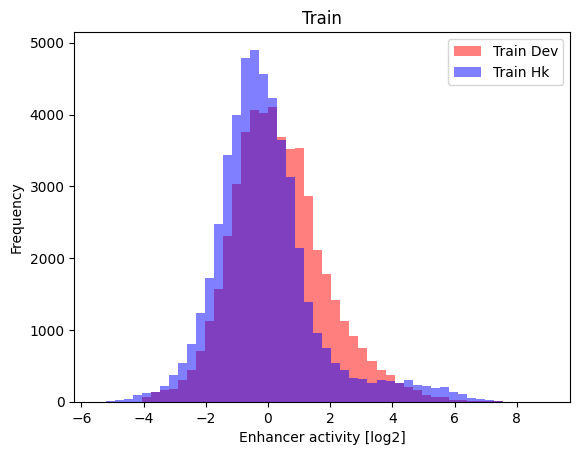

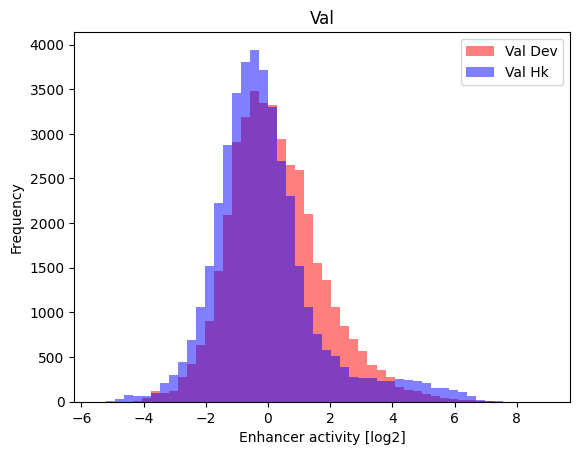

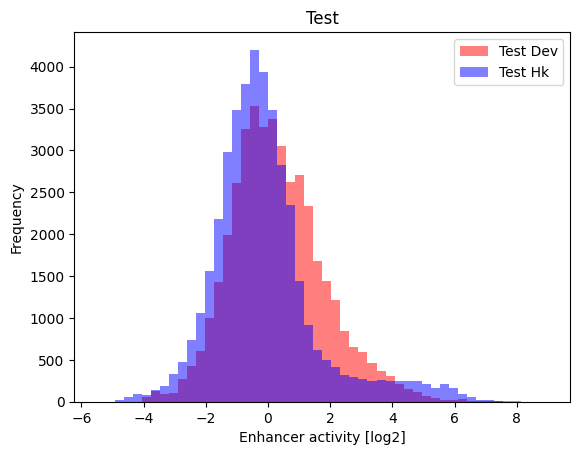

In [ ]:
# Look at distribution of output activities
def hist_activities(set, Y):

  plt.hist(Y[0], alpha=0.5, bins=50, label=set + ' Dev', color='red', range=[-5.5, 9])
  plt.hist(Y[1], alpha=0.5, bins=50, label=set +' Hk', color='blue', range=[-5.5, 9])

  plt.legend(loc='upper right')
  plt.xlabel('Enhancer activity [log2]')
  plt.ylabel('Frequency')
  plt.title(set)

  plt.show()

hist_activities("Train", Y_train)
hist_activities("Val", Y_valid)
hist_activities("Test", Y_test)

## Save data on your Google Drive
Let's save intermediate files in case you want to access it later withour running the cells above.

In [4]:
# First mount drive - you need to permit this notebook to access your Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check folder
!ls
!ls /content/drive/ # Your Drive should be here (MyDrive)

drive  sample_data
MyDrive  Shareddrives


In [ ]:
# This will save the data on Drive
import joblib

joblib.dump(data, '/content/drive/MyDrive/DeepSTARR_tutorial/data')

joblib.dump(X_train, '/content/drive/MyDrive/DeepSTARR_tutorial/X_train')
joblib.dump(Y_train, '/content/drive/MyDrive/DeepSTARR_tutorial/Y_train')

joblib.dump(X_valid, '/content/drive/MyDrive/DeepSTARR_tutorial/X_valid')
joblib.dump(Y_valid, '/content/drive/MyDrive/DeepSTARR_tutorial/Y_valid')

joblib.dump(X_test, '/content/drive/MyDrive/DeepSTARR_tutorial/X_test')
joblib.dump(Y_test, '/content/drive/MyDrive/DeepSTARR_tutorial/Y_test')

['/content/drive/MyDrive/DeepSTARR_tutorial/Y_test']

In [5]:
# data can be loaded like this
import joblib
data = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/data')

X_train = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/X_train')
Y_train = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/Y_train')

X_valid = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/X_valid')
Y_valid = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/Y_valid')

X_test = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/X_test')
Y_test = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/Y_test')


# VAE for sequence generation

Here we will try to use VAE and train it on the same input training data for DeepSTARR,and generate novel enhancer sequences.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers, callbacks

class DNASequenceVAE:
    def __init__(self, seq_length=249, latent_dim=150, params=None):
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.params = params if params is not None else self.default_params()
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()

    def default_params(self):
        # Default parameters in case none are provided
        return {
            'batch_size': 64,
            'epochs': 100,
            'early_stop': 10,
            'lr': 0.001,
            'n_conv_layer': 3,
            'num_filters1': 128,
            'num_filters2': 60,
            'num_filters3': 60,
            'kernel_size1': 7,
            'kernel_size2': 3,
            'kernel_size3': 5,
            'n_dense_layer': 1,
            'dense_neurons1': 64,
            'dropout_conv': 'yes',
            'dropout_prob': 0.4,
            'pad': 'same'
        }

    def build_encoder(self):
        input = layers.Input(shape=(self.seq_length, 4))
        x = input

        # Building convolutional layers based on the number of specified conv layers
        for i in range(1, self.params['n_conv_layer'] + 1):
            x = layers.Conv1D(self.params[f'num_filters{i}'], kernel_size=self.params[f'kernel_size{i}'],
                              padding=self.params['pad'], name=f'Conv1D_{i}')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.MaxPooling1D(2)(x)
            if self.params['dropout_conv'] == 'yes':
                x = layers.Dropout(self.params['dropout_prob'])(x)

        x = layers.Flatten()(x)

        # Adding dense layers
        for i in range(1, self.params['n_dense_layer'] + 1):
            x = layers.Dense(self.params[f'dense_neurons{i}'], name=f'Dense_{i}')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(self.params['dropout_prob'])(x)

        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        z = layers.Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        return Model(input, [z_mean, z_log_var, z], name='encoder')

    def build_decoder(self):
        decoder_input = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(128, activation='relu')(decoder_input)
        x = layers.Dense(64 * self.seq_length, activation='relu')(x)
        x = layers.Reshape((self.seq_length, 64))(x)
        x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
        outputs = layers.Conv1DTranspose(4, 3, activation='softmax', padding='same')(x)
        return Model(decoder_input, outputs, name='decoder')

    def build_vae(self):
        input = layers.Input(shape=(self.seq_length, 4))
        z_mean, z_log_var, z = self.encoder(input)
        vae_output = self.decoder(z)
        vae = Model(input, vae_output, name='vae')
        reconstruction_loss = tf.reduce_mean(losses.categorical_crossentropy(input, vae_output))
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        vae.add_loss(reconstruction_loss + kl_loss)
        vae.compile(optimizer=optimizers.Adam(learning_rate=self.params['lr']))
        return vae

    @staticmethod
    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def train(self, data):
        early_stopping = callbacks.EarlyStopping(monitor='loss', patience=self.params['early_stop'])
        self.vae.fit(data, epochs=self.params['epochs'], batch_size=self.params['batch_size'], callbacks=[early_stopping])

    def generate_dna(self, num_samples=10):
        z_sample = np.random.normal(size=(num_samples, self.latent_dim))
        predictions = self.decoder.predict(z_sample)
        return [self.one_hot_decode_dna(pred) for pred in predictions]

    @staticmethod
    def one_hot_decode_dna(encoded_seq):
        nucleotides = ['A', 'C', 'G', 'T']
        return ''.join([nucleotides[np.argmax(val)] for val in encoded_seq])

# Example of using the DNASequenceVAE class
params = params_smaller_data # assume this is defined as you provided
vae_model = DNASequenceVAE(params=params)
vae_model.train(X_train)  # Ensure training_data is properly formatted and encoded
generated_sequences = vae_model.generate_dna(num_samples=5)


# Train DeepSTARR

Here we will build the DeepSTARR model architecture, train it on the input training data, and evaluate it on the test data.

## Build model architecture

<img src="https://github.com/bernardo-de-almeida/DeepSTARR/blob/main/img/DeepSTARR.png?raw=1" alt="DeepSTARR" width="700"/>

We build the multitask convolutional neural network DeepSTARR to map 249-bp-long DNA sequences tiled across the genome to both their developmental and their housekeeping enhancer activities (Fig. 1c).  
We designed DeepSTARR with four convolution layers, each followed by a max-pooling layer, and two fully connected layers. The convolution layers identify local sequence features (for example, TF motifs) and increasingly complex patterns (for example, TF motif syntax), whereas the fully connected layers combine these features and patterns to predict enhancer activity separately for each enhancer type.

The loss function will be Mean Squared Error (MSE). MSE measures the average squared difference between the predicted values and the actual target values and is commonly used for regression problems. MSE is widely used because it penalizes large errors more heavily than small errors, and it has a well-defined mathematical formula that allows for efficient computation of the gradients during optimization.

## Original implementation (CNN)

In [36]:
### Dictionary containing various hyperparameters for the model, to be more flexible to change them and test different model architectures

# These are the parameters from the main model trained using genome-wide data - more details at https://github.com/bernardo-de-almeida/DeepSTARR/tree/main/DeepSTARR
# params_full_gw_data = {'batch_size': 128,
#                       'epochs': 100,
#                       'early_stop': 5,
#                       'lr': 0.002,
#                       'n_conv_layer': 4,
#                       'num_filters1': 256,
#                       'num_filters2': 60,
#                       'num_filters3': 60,
#                       'num_filters4': 120,
#                       'kernel_size1': 7,
#                       'kernel_size2': 3,
#                       'kernel_size3': 5,
#                       'kernel_size4': 3,
#                       'n_dense_layer': 2,
#                       'dense_neurons1': 256,
#                       'dense_neurons2': 256,
#                       'dropout_conv': 'no',
#                       'dropout_prob': 0.4,
#                       'pad':'same'}


# Here we will adapt the model architecture for the training with the smaller data
# note the reduction in the number of layers, filters, neurons, addition of dropout on the convolutional layers
# this model has 165,354 parameters compared with 624,738 from the full model above
params_smaller_data = {'batch_size': 64, # number of examples per batch
                      'epochs': 1, # number of epochs
                      'early_stop': 10, # patience of 10 epochs to reduce training time; you can increase the patience to see if the model improves after more epochs
                      'lr': 0.001, # learning rate
                      'n_conv_layer': 3, # number of convolutional layers
                      'num_filters1': 128, # number of filters/kernels in the first conv layer
                      'num_filters2': 60, # number of filters/kernels in the second conv layer
                      'num_filters3': 60, # number of filters/kernels in the third conv layer
                      # 'num_filters4': 120,
                      'kernel_size1': 7, # size of the filters in the first conv layer
                      'kernel_size2': 3, # size of the filters in the second conv layer
                      'kernel_size3': 5, # size of the filters in the third conv layer
                      # 'kernel_size4': 3,
                      'n_dense_layer': 1, # number of dense/fully connected layers
                      'dense_neurons1': 64, # number of neurons in the dense layer
                      # 'dense_neurons2': 256,
                      'dropout_conv': 'yes', # add dropout after convolutional layers?
                      'dropout_prob': 0.4, # dropout probability
                      'pad':'same'}

def DeepSTARR(params):

    # expects sequences of length 249 with 4 channels, length of DNA sequences
    input = kl.Input(shape=(249, 4))

    # Body - 4 conv + batch normalization + ReLu activation + max pooling
    # The number of convolutional layers and their hyperparameters are determined by the values in the params dictionary.
    x = kl.Conv1D(params['num_filters1'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1')(input)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('relu')(x)
    x = kl.MaxPooling1D(2)(x)

    for i in range(1, params['n_conv_layer']):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.MaxPooling1D(2)(x)
        # add dropout after convolutional layers?
        if params['dropout_conv'] == 'yes': x = kl.Dropout(params['dropout_prob'])(x)

    # After the convolutional layers, the output is flattened and passed through a series of fully connected/dense layers
    # Flattening converts a multi-dimensional input (from the convolutions) into a one-dimensional array (to be connected with the fully connected layers
    x = kl.Flatten()(x)
    #x = kl.LSTM(64, return_sequences=False)(x)
    # Fully connected layers
    # Each fully connected layer is followed by batch normalization, ReLU activation, and dropout
    for i in range(0, params['n_dense_layer']):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.Dropout(params['dropout_prob'])(x)

    # Main model bottleneck
    bottleneck = x

    # heads per task (developmental and housekeeping enhancer activities)
    # The final output layer is a pair of dense layers, one for each task (developmental and housekeeping enhancer activities), each with a single neuron and a linear activation function
    tasks = ['Dev', 'Hk']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name=str('Dense_' + task))(bottleneck))

    # Build Keras model object
    model = Model([input], outputs)
    model.compile(Adam(learning_rate=params['lr']), # Adam optimizer
                  loss=['mse', 'mse'], # loss is Mean Squared Error (MSE)
                  loss_weights=[1, 1]) # in case we want to change the weights of each output. For now keep them with same weights

    return model, params

# Having the paramters as a variable adds flexibility in case you want to test other architectures
DeepSTARR(params_smaller_data)[0].summary() # plot model architecture
DeepSTARR(params_smaller_data)[1] # show dictionary

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 249, 4)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 249, 128)             3712      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_27 (Ba  (None, 249, 128)             512       ['Conv1D_1[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_27 (Activation)  (None, 249, 128)             0         ['batch_normalization_2

{'batch_size': 64,
 'epochs': 1,
 'early_stop': 10,
 'lr': 0.001,
 'n_conv_layer': 3,
 'num_filters1': 128,
 'num_filters2': 60,
 'num_filters3': 60,
 'kernel_size1': 7,
 'kernel_size2': 3,
 'kernel_size3': 5,
 'n_dense_layer': 1,
 'dense_neurons1': 64,
 'dropout_conv': 'yes',
 'dropout_prob': 0.4,
 'pad': 'same'}

## My implementation (CNN + Transformer)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers as kl
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

params_smaller_data = {
    'batch_size': 64,
    'epochs': 1,
    'early_stop': 20,
    'lr': 0.001,
    'n_conv_layer': 3,
    'num_filters1': 128,
    'num_filters2': 60,
    'num_filters3': 60,
    'kernel_size1': 7,
    'kernel_size2': 3,
    'kernel_size3': 5,
    'n_dense_layer': 1,
    'dense_neurons1': 64,
    'dropout_conv': 'yes',
    'dropout_prob': 0.4,
    'pad': 'same',
    'num_heads': 4,  # number of attention heads
    'dff': 128,  # depth of the feed-forward network
    'sequence_length': 249  # adjust based on your data
}


def positional_encoding(positions, d_model):
    positions = tf.range(positions, dtype=tf.float32)[:, tf.newaxis]  # Explicitly cast to float32
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]  # Explicitly cast to float32
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = positions * angle_rates
    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return pos_encoding

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, position=None):
    # Add Positional Encoding
    # Calculate effective sequence length after pooling
    #effective_length = 2000 // (2 ** params['n_conv_layer'])
    #pos_encoding = positional_encoding(effective_length, params['num_filters' + str(params['n_conv_layer'])])
    #x = input + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)  # Add positional encoding to the transformer input
    # Calculate effective sequence length after pooling
    effective_length = inputs.shape[1]
    pos_encoding = positional_encoding(effective_length, inputs.shape[-1])
    pos_encoding = tf.expand_dims(pos_encoding, 0)
    x = kl.Add()([inputs,pos_encoding])  # Add positional encoding to the transformer input

    # First MultiHeadAttention Layer
    x = kl.LayerNormalization(epsilon=1e-6)(inputs)
    x = inputs
    x = kl.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = kl.Dropout(dropout)(x)
    x = kl.Add()([x,inputs])  # Skip Connection

    # Second MultiHeadAttention Layer
    x = kl.LayerNormalization(epsilon=1e-6)(x)
    x = kl.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = kl.Dropout(dropout)(x)
    x = kl.Add()([x,inputs])  # Skip Connection again


    # Feed Forward Part
    x = kl.LayerNormalization(epsilon=1e-6)(x)
    x = kl.Dense(ff_dim, activation="relu")(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(inputs.shape[-1])(x)
    return kl.Add()([x,inputs])  # Skip Connection

def DeepSTARR(params):
    input = kl.Input(shape=(params['sequence_length'], 4))

    # Convolutional layers as before
    x = kl.Conv1D(params['num_filters1'], kernel_size=params['kernel_size1'],
                  padding=params['pad'], name='Conv1D_1')(input)
    x = kl.BatchNormalization()(x)
    x = kl.Activation('relu')(x)
    x = kl.MaxPooling1D(2)(x)

    for i in range(1, params['n_conv_layer']):
        x = kl.Conv1D(params['num_filters' + str(i + 1)],
                      kernel_size=params['kernel_size' + str(i + 1)],
                      padding=params['pad'], name='Conv1D_' + str(i + 1))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.MaxPooling1D(2)(x)
        if params['dropout_conv'] == 'yes':
            x = kl.Dropout(params['dropout_prob'])(x)

    # Transformer layer with positional encoding
    x = transformer_encoder(x, head_size=64, num_heads=params['num_heads'], ff_dim=params['dff'], dropout=params['dropout_prob'], position=params['sequence_length']//4)

    # Dense layers as before
    x = kl.Flatten()(x)
    for i in range(0, params['n_dense_layer']):
        x = kl.Dense(params['dense_neurons' + str(i + 1)], name='Dense_' + str(i + 1))(x)
        x = kl.BatchNormalization()(x)
        x = kl.Activation('relu')(x)
        x = kl.Dropout(params['dropout_prob'])(x)

    bottleneck = x
    tasks = ['Dev', 'Hk']
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='linear', name='Dense_' + task)(bottleneck))

    model = Model([input], outputs)
    model.compile(Adam(learning_rate=params['lr']),
                  loss=['mse', 'mse'],
                  loss_weights=[1, 1])

    return model, params

model, params = DeepSTARR(params_smaller_data)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


TypeError: Cannot convert Dimension 31 to dtype <dtype: 'float32'>. Allowed dtypes are tf.int32 and tf.int64.

## Train model

During model training, the model learns to make predictions on the provided data by updating its weights based on the loss between the predicted values and the actual values.  
The goal of training is to minimize the difference between the predicted values and the actual values, which is achieved by finding the set of weights that produce the lowest loss on the training data.

In more detail, the training process involves the following steps:
- The model takes in the input data (training data) and produces a set of predicted values
- The predicted values are compared to the actual values using a loss function - in this case mean squared error (MSE)
- The optimizer updates the model's weights in order to minimize the loss (using backpropagation and gradient descent)
- The process is repeated for the specified number of epochs or until a stopping criterion is met (here no improvement in validation loss)
- Once training is complete, the trained model can be used to make predictions on new data (e.g. test set).

An epoch is a single iteration through the entire training dataset. During each epoch, the model updates its parameters based on the optimization algorithm, and then the validation loss is calculated using the validation set. Too few epochs may result in an underfit model that hasn't fully captured the underlying pattern in the training data, while too many epochs may lead to overfitting where the model performs well on the training data but poorly on the validation data.

<img src="https://storage.googleapis.com/kaggle-media/learn/images/eP0gppr.png" alt="loss" width="450"/>

During the training process, it is important to monitor the performance of the model on a validation set, which provides an estimate of the model's ability to generalize to new data (e.g. test set). The training process can be adjusted based on the performance on the validation set to prevent overfitting or underfitting. Here we used EarlyStopping to stop the training after some epochs of no improvement in the validation set.

The test set should never be used until we have the final model. The final model performance is then evaluated on the test set data.

In [ ]:
# function to to train model
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train, Y_train,
                                  validation_data=(X_valid, Y_valid), # The function trains the selected_model using the training data and validates it using the validation data.
                                  batch_size=params['batch_size'],
                                  epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True), # The training will stop early if there is no improvement in validation loss after a certain number of epochs (patience)
                                             History()])

    # save model and history
    return selected_model, my_history

In [37]:
# Create model with specified parameters
# main_model, main_params = DeepSTARR(params_full_gw_data) # training the full model with the full training data takes almost all the GPU resources in Colab, but it's possible if you want to try
main_model, main_params = DeepSTARR(params_smaller_data) # adapted model architecture for smaller training set

# Run training, should take less than 10min, depending on when early stopping is activated
# Monitor model performance for each epoch

# We have two outputs (developmental and housekeeping), so there are two losses (Dense_Dev_loss, Dense_Hk_loss) and the final combined (loss; which is the sum) - for training and validation sets separately
# In each epoch, training occurs per batch of specified size.
# The batch size is the number of samples processed before the model's parameters are updated during a single iteration of the optimization algorithm. The number of epochs is the number of complete passes through the whole training dataset.
# Training's loss is calculated for the current batch and averaged successively during the epoch.
# Validation loss displays the loss of all the validation batches, at the end of each epoch.
main_model, my_history = train(main_model, X_train, Y_train, X_valid, Y_valid, main_params)

782/782 [==============================] - 148s 184ms/step - loss: 5.2449 - Dense_Dev_loss: 2.4577 - Dense_Hk_loss: 2.7872 - val_loss: 5.1232 - val_Dense_Dev_loss: 2.3510 - val_Dense_Hk_loss: 2.7722


## Evaluate the model

Evaluate the model through:
- looking at training and validation metrics in model training history
- assessing performance in held-out test set (e.g. Pearson and Spearman correlations)
- Plot the data and compare actual values with predicted ones for the test set

Note that the model training results will vary if you run it different times due to the random initialization of weights.

### Training history

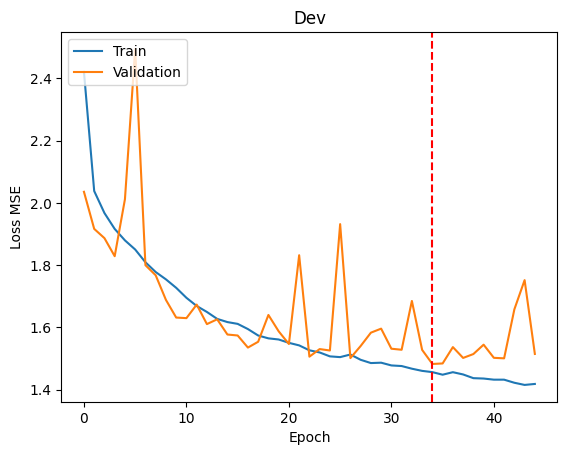

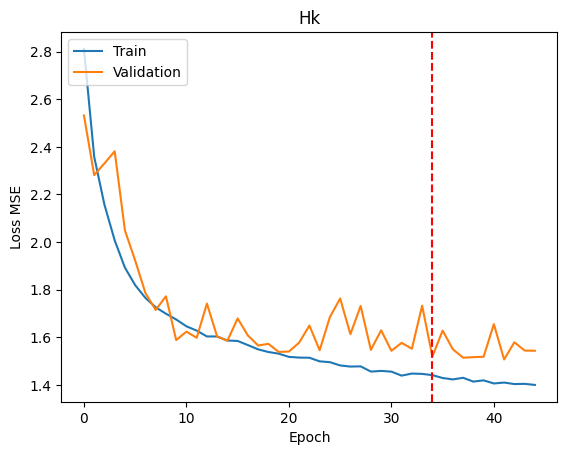

In [ ]:
# Plot training & validation training metrics
for out in ['Dev', 'Hk']:
  # MSE
  plt.plot(my_history.history[str('Dense_' + out + '_loss')])
  plt.plot(my_history.history[str('val_Dense_' + out + '_loss')])
  plt.title(out) # loss is Mean Squared Error (MSE)
  plt.ylabel('Loss MSE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Add vertical line at minimum validation loss of combined dev and hk
  min_val_loss = min(my_history.history['val_loss'])
  plt.axvline(x=my_history.history['val_loss'].index(min_val_loss), color='red', linestyle='--')

  plt.show()

### Model performance metrics

Analyse Mean Squared Error (MSE) and Pearson (PCC) and Spearman (SCC) correlation coefficients

In [ ]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(X, Y, set, task):
    pred = main_model.predict(X, batch_size=main_params['batch_size']) # predict
    if task =="Dev":
        i=0
    if task =="Hk":
        i=1
    print(set + ' MSE ' + task + ' = ' + str("{0:0.2f}".format(mean_squared_error(Y, pred[i].squeeze()))))
    print(set + ' PCC ' + task + ' = ' + str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0])))
    # print(set + ' SCC ' + task + ' = ' + str("{0:0.2f}".format(stats.spearmanr(Y, pred[i].squeeze())[0]))) # not giving similar results as training

# predict activity for each set and enhancer type
summary_statistics(X_train, Y_train[0], "train", "Dev")
summary_statistics(X_valid, Y_valid[0], "validation", "Dev")
summary_statistics(X_test, Y_test[0], "test", "Dev")

summary_statistics(X_train, Y_train[1], "train", "Hk")
summary_statistics(X_valid, Y_valid[1], "validation", "Hk")
summary_statistics(X_test, Y_test[1], "test", "Hk")

782/782 [==============================] - 5s 6ms/step
train MSE Dev = 1.26
train PCC Dev = 0.68
634/634 [==============================] - 3s 5ms/step
validation MSE Dev = 1.52
validation PCC Dev = 0.60
644/644 [==============================] - 3s 5ms/step
test MSE Dev = 1.51
test PCC Dev = 0.61
782/782 [==============================] - 4s 5ms/step
train MSE Hk = 1.24
train PCC Hk = 0.75
634/634 [==============================] - 3s 5ms/step
validation MSE Hk = 1.57
validation PCC Hk = 0.70
644/644 [==============================] - 4s 7ms/step
test MSE Hk = 1.49
test PCC Hk = 0.72


Although there is some overfitting (i.e. the performance is better in the training set than test set), the performance on the test data is still good. This suggests that the model accurately captures the regulatory information present in the DNA sequences, as you will see in the sections below.

### Scatter plots
The scatter plots compare the observed values with the predicted ones for each set of sequences (train/validation/testing). This allows to compare the global performance of the final model.

644/644 [==============================] - 3s 5ms/step


<ipython-input-53-aa7e772c00a2>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w" (-> color=(1.0, 1.0, 1.0, 1)). The keyword argument will take precedence.
  g.plot(lims, lims, 'w', linestyle='dashed', transform=g.transData, color='grey')


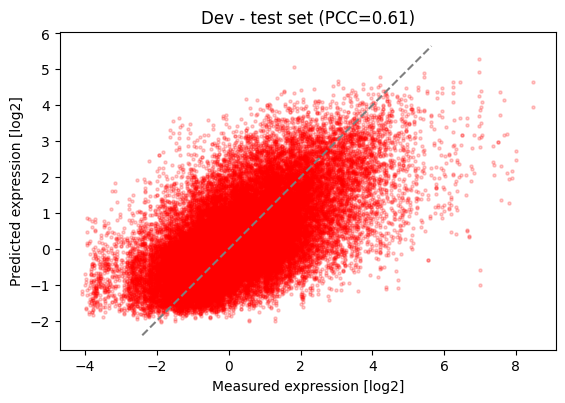

644/644 [==============================] - 4s 6ms/step


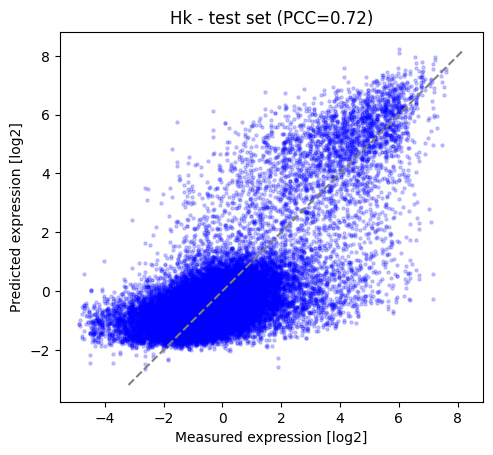

In [ ]:
def my_scatter(X, Y, set, task):
  pred = main_model.predict(X, batch_size=main_params['batch_size'])
  if task =="Dev":
    i=0
    c="red"
  if task =="Hk":
    i=1
    c="blue"

  g = sns.regplot(x=Y, y=pred[i].squeeze(), ci=None, color=c,
                  fit_reg=False,
                  scatter_kws={'s': 5, 'alpha': 0.2},
                  line_kws={'color': "black"})

  # add expected regression line
  x0, x1 = g.get_xlim()
  y0, y1 = g.get_ylim()
  lims = [max(x0, y0), min(x1, y1)]
  g.plot(lims, lims, 'w', linestyle='dashed', transform=g.transData, color='grey')

  # same axes ranges
  g.set_aspect('equal')
  # g.set(xlim=(min(x0, y0), max(x1, y1)),
  #       ylim=(min(x0, y0), max(x1, y1)))

  PCC = str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0]))
  plt.xlabel('Measured expression [log2]')
  plt.ylabel('Predicted expression [log2]')
  plt.title(str(task + ' - ' + set + ' set (PCC=' + PCC + ')'))

  plt.show()

# plots
my_scatter(X_test, Y_test[0], "test", "Dev")
my_scatter(X_test, Y_test[1], "test", "Hk")

644/644 [==============================] - 3s 5ms/step


KeyboardInterrupt: 

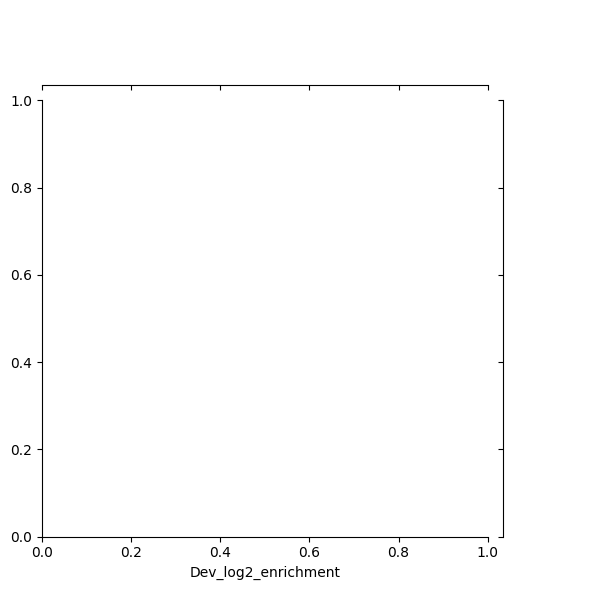

In [ ]:
### smoothscatter plot - useful when there are thousands of points

# takes some time to calculate the kernel density
def my_scatter_density(X, Y, set, task):
  pred = main_model.predict(X, batch_size=main_params['batch_size'])
  if task =="Dev":
    i=0
    c="red"
  if task =="Hk":
    i=1
    c="blue"

  g = sns.jointplot(x=Y, y=pred[i].squeeze(), kind="kde", fill=True, color=c)
  g.ax_marg_x.remove() # remove marginal densities
  g.ax_marg_y.remove() # remove marginal densities

  # add regression line of data
  # sns.regplot(x=Y, y=pred[i].squeeze(), scatter=False, color='black', ax=g.ax_joint)

  # add expected regression line
  x0, x1 = g.ax_joint.get_xlim()
  y0, y1 = g.ax_joint.get_ylim()
  lims = [max(x0, y0), min(x1, y1)]
  g.ax_joint.plot(lims, lims, 'w', linestyle='dashed', transform=g.ax_joint.transData, color='grey')

  # same axes ranges
  g.ax_joint.set_aspect('equal')

  PCC = str("{0:0.2f}".format(stats.pearsonr(Y, pred[i].squeeze())[0]))
  plt.xlabel('Measured expression [log2]')
  plt.ylabel('Predicted expression [log2]')
  plt.title(str(task + ' - ' + set + ' set (PCC=' + PCC + ')'))

  plt.show()

# print plots for test sets
my_scatter_density(X_test, Y_test[0], "test", "Dev")
my_scatter_density(X_test, Y_test[1], "test", "Hk")

## Save model

In [ ]:
# This will save it on the current session's memory
main_model.save('my_DeepSTARR_model.h5')

### Save model on your Google Drive

In [ ]:
# Check folder
!ls
!ls /content/drive/ # Your Drive should be here (MyDrive)

drive  sample_data
MyDrive  Shareddrives


In [ ]:
# This will save it on Google Drive
main_model.save('/content/drive/MyDrive/DeepSTARR_tutorial/my_DeepSTARR_transformer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction on generated enhancers

In [ ]:
# define a dictionary to map nucleotides to their one-hot encoded representation
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# function to load sequences and enhancer activity
def prepare_input(data_set):
  # one-hot encode DNA sequences, apply function
  seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())
  print(seq_matrix.shape) # dimensions are (number of sequences, length of sequences, nucleotides)
  return seq_matrix

In [ ]:
generated_seqs = pd.DataFrame(generated_seqs,columns=['Sequence'])
generated_seqs = prepare_input(generated_seqs)

(1000, 249, 4)


In [ ]:
generated_seq_pred = main_model.predict(generated_seqs, batch_size=main_params['batch_size'])

16/16 [==============================] - 0s 10ms/step


In [ ]:
generated_seq_pred[0][2]

array([0.20341662], dtype=float32)

In [ ]:
generated_seq_pred[1][2]

array([-0.63547945], dtype=float32)

# Nucleotide contribution scores

<img src="https://bernardo-de-almeida.github.io/tutorials/DeepLearning_genomics/DeepSTARR_nucl_scores.png" alt="Nucl scores" width="700"/>

To understand the features and rules learned by DeepSTARR, we can quantify how each individual nucleotide in every sequence contributes to the predicted developmental and housekeeping enhancer activities.  
We will use [DeepExplainer](https://github.com/slundberg/shap/#deep-learning-example-with-deepexplainer-tensorflowkeras-models) (the DeepSHAP implementation of [DeepLIFT](https://arxiv.org/abs/1704.02685); more details in the [GitHub repository](https://github.com/kundajelab/deeplift)). This method works by decomposing the output prediction of a neural network on a specific input by backpropagating the contributions of all neurons in the network to every feature of the input. Scores can be computed efficiently in a single backward pass.  
More specifically, it explains the difference in the output relative to what the output is under some "reference" input. The ‘reference’ state is a distribution of background samples, chosen according to
what is appropriate for the problem at hand. Since it uses backpropagation, it can compute all scores at once, making it more efficient than in-silico mutagenesis (i.e. mutating every nucleotide and measuring its impact of the predicted value).

Above is an example of a developmental enhancer and its derived nucleotide contribution scores. Regions with high scores resembling known TF motifs are highlighted. These important/predictive motifs were learned *de novo* by the model.

## Install modules

In [ ]:
!pip uninstall shap --yes

Found existing installation: shap 0.45.1
Uninstalling shap-0.45.1:
  Successfully uninstalled shap-0.45.1


In [ ]:
!pip install shap

!pip install deeplift

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for deeplift: filename=deeplift-0.6.13.0-py3-none-any.whl size=36425 sha256=9bda512d0c04d82127dcc56233dbd1314ccdb8c667dee7135f4a64d001d799ad
  Stored in directory: /root/.cache/pip/wheels/5d/d0/62/3f2d52f229601a9107ad95750d9b403c66063756100d374b6f
Successfully built deeplift


In [ ]:
# check module versions
print(tf.__version__)

import shap
print(shap.__version__)

# import deeplift
# print(deeplift.__version__)

2.15.0
0.45.1


## Load the model

Either load back the model trained above or the final model from the DeepSTARR paper trained on the whole training data

In [ ]:
# Load the final model trained above
main_model = load_model('/content/drive/MyDrive/DeepSTARR_tutorial/my_DeepSTARR_transformer_model.h5')

In [ ]:
main_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 249, 4)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 249, 128)             3712      ['input_28[0][0]']            
                                                                                                  
 batch_normalization_89 (Ba  (None, 249, 128)             512       ['Conv1D_1[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_89 (Activation)  (None, 249, 128)             0         ['batch_normalization_89

In [ ]:
# Or load the final DeepSTARR model from the paper, trained on the whole training set (it's a retrained version, not the original one, but it's fine)
# It's more accurate than the one trained above on a subset of data
# It's available from the link below

# download model file
model_url = 'https://drive.google.com/uc?id=170d_WWlrM22xRzu0PbQmBjT2akvZ2ndn' # link to model trained on genome-wide data
output_path = 'DeepSTARR_model_gw_data.h5'
gdown.download(model_url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=170d_WWlrM22xRzu0PbQmBjT2akvZ2ndn
To: /content/DeepSTARR_model_gw_data.h5
100%|██████████| 7.62M/7.62M [00:00<00:00, 10.1MB/s]


'DeepSTARR_model_gw_data.h5'

In [ ]:
# check files in folder - see the model file there
!ls -lh

total 9.3M
-rw-r--r-- 1 root root 7.3M Apr 27 14:20 DeepSTARR_model_gw_data.h5
-rw-r--r-- 1 root root 2.0M Apr 27 14:17 my_DeepSTARR_model.h5
drwxr-xr-x 1 root root 4.0K Apr 25 13:34 sample_data


In [ ]:
# Load model
paper_model = load_model(output_path)

In [ ]:
paper_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 249, 4)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 249, 256)             7424      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_12 (Ba  (None, 249, 256)             1024      ['Conv1D_1[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 249, 256)             0         ['batch_normalization_12

In [ ]:
# check model architecture
main_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 249, 4)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 249, 128)             3712      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 249, 128)             512       ['Conv1D_1[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 249, 128)             0         ['batch_normalization_1

## Calculate and visualise contribution scores

<img src="https://bernardo-de-almeida.github.io/tutorials/DeepLearning_genomics/DeepSTARR_nucl_scores_examples.png" alt="Nucl scores examples" width="1000"/>
DeepSTARR-derived Developmental and Housekeeping nucleotide contribution scores for a strong Developmental (left) and a strong Housekeeping (right) enhancer sequence, as example. Regions with high scores resembling known TF motifs are highlighted.

In [ ]:
### Check to which layer should we get the input nucleotide contributions
main_model.layers
# second to last layer is the Developmental activity final Dense layer: main_model.layers[-2]
# last layer is the Housekeeping activity final Dense layer: main_model.layers[-1]

# when using a sigmoid activation as final activation, compute the scores relative to the pre-sigmoid activation

### Prepare DeepExplainer

In [ ]:
!pip uninstall numpy --y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.26.4

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)


In [38]:
import shap
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()

# import tensorflow.compat.v1.keras.backend as K
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()


# select a set of background examples to take an expectation over
np.random.seed(seed=1234)
background = X_test[np.random.choice(X_test.shape[0], 1000, replace=False)]

# Prepare DeepExplainer for developmental and housekeeping model output
shap.explainers._deep.deep_tf.op_handlers["Einsum"] = shap.explainers._deep.deep_tf.passthrough # this is required due to conflict between versions (https://github.com/slundberg/shap/issues/1110)
explainer_dev = shap.DeepExplainer((main_model.layers[0].input, main_model.layers[-2].output),
                                  data=background)
explainer_hk = shap.DeepExplainer((main_model.layers[0].input, main_model.layers[-1].output),
                                  data=background)

# ignore the warnings about keras

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [28]:
main_model.layers[0].input

<KerasTensor: shape=(None, 249, 4) dtype=float32 (created by layer 'input_2')>

In [27]:
main_model.layers[-2].output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Dense_Dev')>

In [ ]:
input_layer = main_model.layers[0].input
output_layer1 = main_model.layers[-2].output  # Second last layer output
output_layer2 = main_model.layers[-1].output  # Last layer output

combined_output = tf.keras.layers.Concatenate(axis=-1)([output_layer1, output_layer2])

combined_model = Model(inputs=input_layer, outputs=combined_output)

background = generated_seqs[np.random.choice(generated_seqs.shape[0], 100, replace=False)]  # Background data
explainer_combined = shap.DeepExplainer(combined_model, data=background)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


### Developmental enhancers

We will run it on a selected set of enhancers from the test set to be faster, but this could be run across all enhancers.

In [ ]:
main_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 249, 4)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 249, 128)             3712      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 249, 128)             512       ['Conv1D_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 249, 128)             0         ['batch_normalization_8

In [42]:
### Compute nucleotide contribution scores to developmental enhancers - takes ~3mins for this number of sequences

# get strong developmental enhancers from test set
# cand_dev = data.loc[(data['set'] == 'Test') &
#                     # (data['Oligo_ID'].str.contains('_\+_wt_dCP')) & # not working in some pandas version
#                     (data['Dev_log2_enrichment'] > 4)]
# cand_dev = cand_dev.set_index('Oligo_ID').filter(regex='_\+_wt_dCP', axis=0)

# Enhancer sequences have the label 'positive_peaks' on the column 'ID' - we will need that for the contribution scores later
cand_dev = data.loc[(data['set'] == 'Test') &
                    (data['ID'].str.contains('_\+_positive_peaks')) & # not working in some pandas version
                    (data['Dev_log2_enrichment'] > 3)]
# cand_dev = cand_dev.set_index('ID', drop=False).filter(regex='_\+_positive_peaks', axis=0) # if str.contains doesn't work

# sort by strength to have the stongest on top for later plotting
cand_dev = cand_dev.sort_values('Dev_log2_enrichment', ascending = False)[:5]
#print(cand_dev)

# one-hot encode sequences
X_cand_dev, Y_cand_dev = prepare_input(cand_dev)

# Predict activity with model
pred_values_dev = main_model.predict(X_cand_dev)[0].squeeze() # 0 output for developmental


# calculate scores, get first element of output
shap_values_dev = explainer_dev.shap_values(X_cand_dev)[0]

(5, 249, 4)


ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [ ]:
# Look at scores of one sequence, first 6 nucleotides - these are the hypothetical contribution scores
# rows are nucleotide positions, columns are A,C,G,T
shap_values_dev[0,:6]

array([[ 5.48347768e-05],
       [ 1.49079299e-03],
       [-1.80816251e-04],
       [ 3.59372993e-03]])

These scores are for every nucleotide possibility in each position - called **Hypothetical scores**. They  can be thought of as quick estimates of what the contribution *would have been* if a different base were present.  
Hypothetical scores are used as input to the importance score clustering algorithm TF-Modisco (https://github.com/kundajelab/tfmodisco).  
Hypothetical importance scores are discussed more in this pull request: https://github.com/kundajelab/deeplift/pull/36.
<br></br>
To obtain the **actual contribution scores** for each sequence, below we multiply the hypothetical scores by the one-hot data - we use the contribution of whichever base was present.

In [ ]:
# multiply by one-hot sequence to keep only the scores of the actual nucleotides
final_contr_scores_dev = shap_values_dev*X_cand_dev
print(cand_dev.iloc[0]['Sequence'][:6]) # check DNA sequence
print(final_contr_scores_dev[0,:6]) # check scores - nucleotides should match DNA sequence

TTTGAC
[[ 0.          0.         -0.          0.00184663]
 [-0.          0.          0.         -0.00691903]
 [ 0.         -0.          0.          0.00623773]
 [ 0.          0.          0.00139746 -0.        ]
 [-0.00112095 -0.          0.          0.        ]
 [ 0.          0.0022502   0.          0.        ]]


Enhancer: chr2R_17033214_17033462_+_positive_peaks  / Obs act: 8.48  / Pred act: 7.29
Actual contribution scores


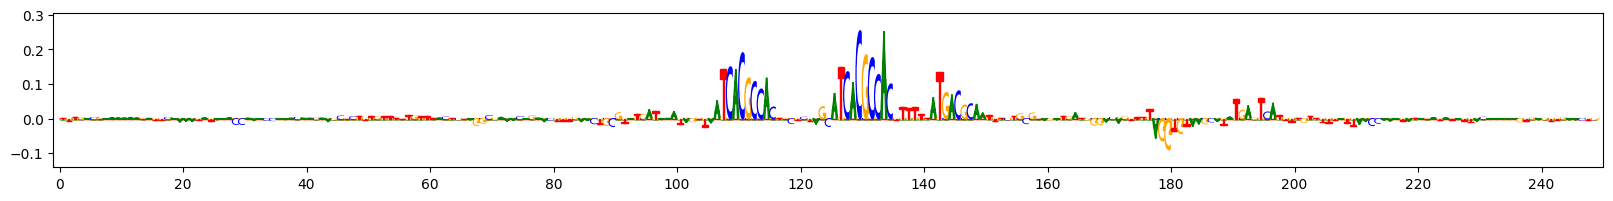

Enhancer: chr2R_20148203_20148451_+_positive_peaks  / Obs act: 7.99  / Pred act: 4.07
Actual contribution scores


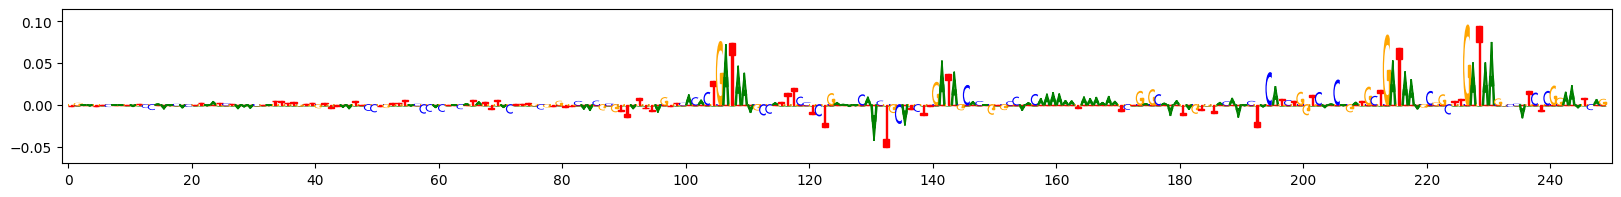

Enhancer: chr2R_12017448_12017696_+_positive_peaks  / Obs act: 7.90  / Pred act: 1.37
Actual contribution scores


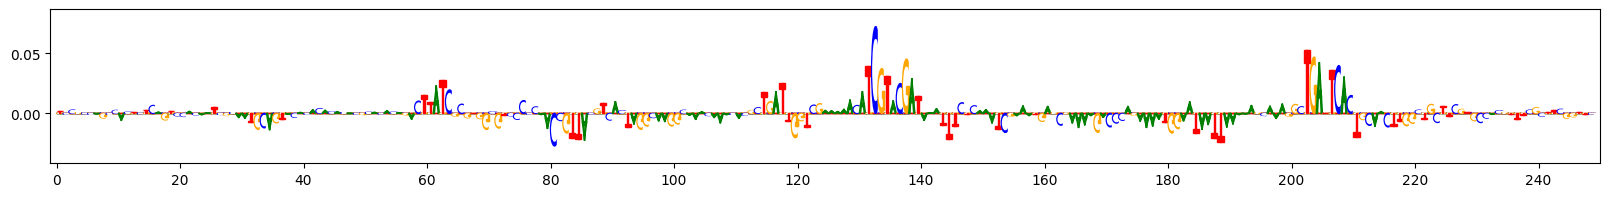

Enhancer: chr2R_14733006_14733254_+_positive_peaks  / Obs act: 7.60  / Pred act: 5.77
Actual contribution scores


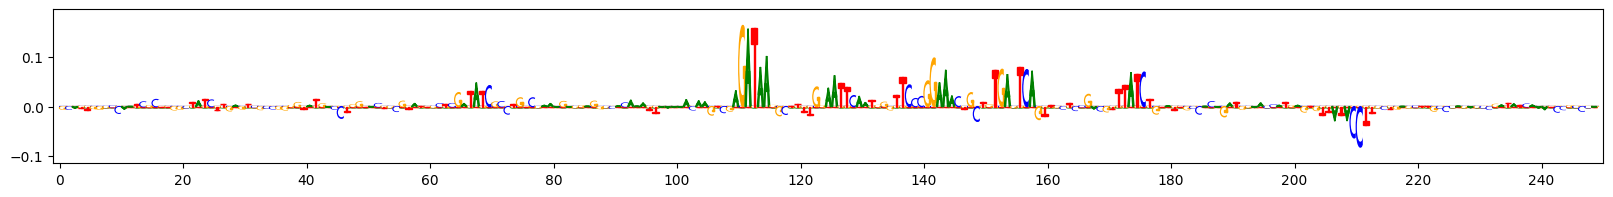

Enhancer: chr2R_12014475_12014723_+_positive_peaks  / Obs act: 7.40  / Pred act: 3.43
Actual contribution scores


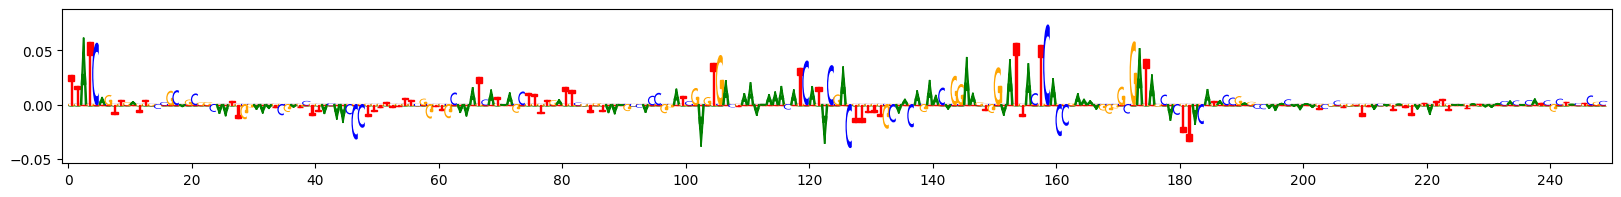

In [ ]:
### Plot scores of some top enhancers
from deeplift.visualization import viz_sequence # function from https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/deeplift/visualization/viz_sequence.py

for i in range(5):
    print('Enhancer:', cand_dev.iloc[i]['ID'],
          ' / Obs act:', '{0:0.2f}'.format(cand_dev.iloc[i]['Dev_log2_enrichment']),
          ' / Pred act:', '{0:0.2f}'.format(pred_values_dev[i]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(final_contr_scores_dev[i], figsize=(20,2), subticks_frequency=20)

    # print('Hypothetical contribution scores')
    # viz_sequence.plot_weights(shap_values_dev[i], figsize=(20,2), subticks_frequency=20)


See how TF motifs are nicely highlighted as predictive of enhancer activity by the model!  
These were learned de novo in the convolutional filters  and match known developmental TF motifs.

### Housekeeping enhancers

We will run it on a selected set of enhancers from the test set to be faster, but this could be run across all enhancers.

In [ ]:
### Compute nucleotide contribution scores to developmental enhancers - takes ~3mins for this number of sequences

# get strong developmental enhancers from test set
# cand_hk = data.loc[(data['set'] == 'Test') &
#                     # (data['Oligo_ID'].str.contains('_\+_wt_dCP')) & # not working in some pandas version
#                     (data['Hk_log2_enrichment'] > 3)]
# cand_hk = cand_hk.set_index('Oligo_ID').filter(regex='_\+_wt_hkCP', axis=0)

# Enhancer sequences have the label 'positive_peaks' on the column 'ID' - we will need that for the contribution scores later
cand_hk = data.loc[(data['set'] == 'Test') &
                    (data['ID'].str.contains('_\+_positive_peaks')) & # not working in some pandas version
                    (data['Hk_log2_enrichment'] > 3)]
# cand_hk = cand_hk.set_index('ID', drop=False).filter(regex='_\+_positive_peaks', axis=0) # if str.contains doesn't work

# sort by strength to have the stongest on top for later plotting
cand_hk = cand_hk.sort_values('Hk_log2_enrichment', ascending = False)
print(cand_hk)

# one-hot encode sequences
X_cand_hk, Y_cand_hk = prepare_input(cand_hk)

# Predict activity with model
pred_values_hk = main_model.predict(X_cand_hk)[1].squeeze() # 0 output for housekeeping

# calculate scores, get first element of output
shap_values_hk = explainer_hk.shap_values(X_cand_hk)[0]

      seqnames     start       end                                        ID  \
5702     chr2R  15312366  15312614  chr2R_15312366_15312614_+_positive_peaks   
4916     chr2R  10639748  10639996  chr2R_10639748_10639996_+_positive_peaks   
6500     chr2R  20487254  20487502  chr2R_20487254_20487502_+_positive_peaks   
5028     chr2R  11419639  11419887  chr2R_11419639_11419887_+_positive_peaks   
5850     chr2R  16510829  16511077  chr2R_16510829_16511077_+_positive_peaks   
...        ...       ...       ...                                       ...   
5394     chr2R  13606763  13607011  chr2R_13606763_13607011_+_positive_peaks   
20828    chr2R  11997376  11997624  chr2R_11997376_11997624_+_positive_peaks   
20915    chr2R  14022813  14023061  chr2R_14022813_14023061_+_positive_peaks   
5580     chr2R  14687926  14688174  chr2R_14687926_14688174_+_positive_peaks   
20877    chr2R  13011749  13011997  chr2R_13011749_13011997_+_positive_peaks   

        set                            

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
# Look at scores of one sequence, first 6 nucleotides - these are the hypothetical contribution scores
# rows are nucleotide positions, columns are A,C,G,T
shap_values_hk[0,:6]

array([[ 0.00188747,  0.00113462,  0.00289674, -0.00580285],
       [ 0.00778904, -0.0008445 ,  0.01692693,  0.00502351],
       [ 0.00387425, -0.00025299,  0.00196547,  0.00546114],
       [ 0.00906308, -0.00156408,  0.00409602,  0.01083009],
       [-0.00206393,  0.00349273,  0.01237132,  0.00624958],
       [ 0.0010723 ,  0.00021539,  0.0035488 ,  0.00436191]])

These scores are for every nucleotide possibility in each position - called **Hypothetical scores**. They  can be thought of as quick estimates of what the contribution *would have been* if a different base were present.  
Hypothetical scores are used as input to the importance score clustering algorithm TF-Modisco (https://github.com/kundajelab/tfmodisco).  
Hypothetical importance scores are discussed more in this pull request: https://github.com/kundajelab/deeplift/pull/36.
<br></br>
To obtain the **actual contribution scores** for each sequence, below we multiply the hypothetical scores by the one-hot data - we use the contribution of whichever base was present.

In [ ]:
# multiply by one-hot sequence to keep only the scores of the actual nucleotides
final_contr_scores_hk = shap_values_hk*X_cand_hk
print(cand_hk.iloc[0]['Sequence'][:6]) # check DNA sequence
print(final_contr_scores_hk[0,:6]) # check scores

TGATGT
[[ 0.          0.          0.         -0.00580285]
 [ 0.         -0.          0.01692693  0.        ]
 [ 0.00387425 -0.          0.          0.        ]
 [ 0.         -0.          0.          0.01083009]
 [-0.          0.          0.01237132  0.        ]
 [ 0.          0.          0.          0.00436191]]


Enhancer: chr2R_17033214_17033462_+_positive_peaks  / Obs act: 7.60  / Pred act: 6.43
Actual contribution scores


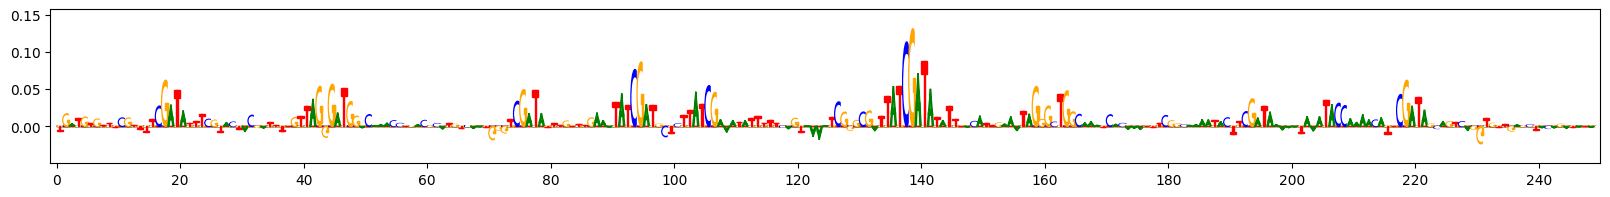

Enhancer: chr2R_20148203_20148451_+_positive_peaks  / Obs act: 7.54  / Pred act: 5.78
Actual contribution scores


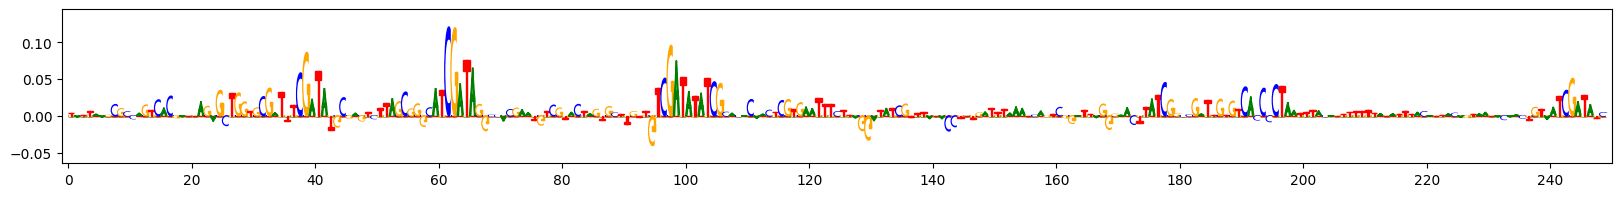

Enhancer: chr2R_12017448_12017696_+_positive_peaks  / Obs act: 7.47  / Pred act: 5.93
Actual contribution scores


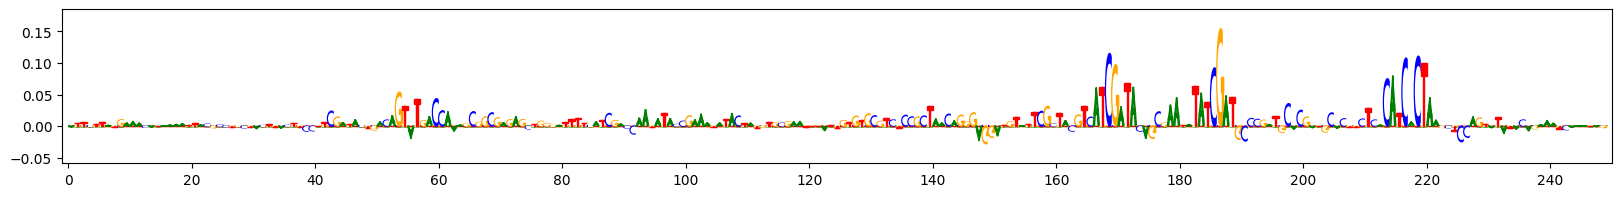

Enhancer: chr2R_14733006_14733254_+_positive_peaks  / Obs act: 7.44  / Pred act: 6.92
Actual contribution scores


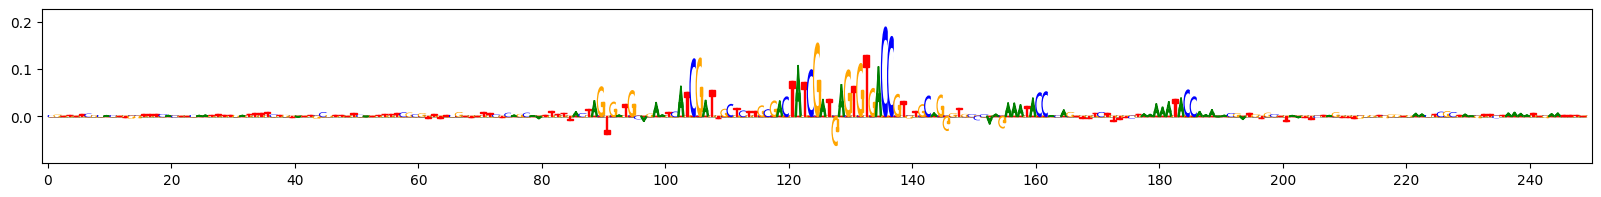

Enhancer: chr2R_12014475_12014723_+_positive_peaks  / Obs act: 7.25  / Pred act: 6.34
Actual contribution scores


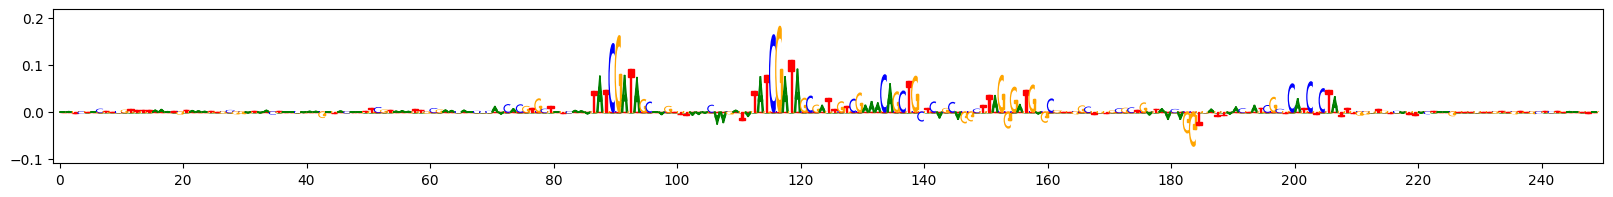

In [ ]:
### Plot scores of some top enhancers
from deeplift.visualization import viz_sequence # function from https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/deeplift/visualization/viz_sequence.py

for i in range(5):
    print('Enhancer:', cand_dev.iloc[i]['ID'],
          ' / Obs act:', '{0:0.2f}'.format(cand_hk.iloc[i]['Hk_log2_enrichment']),
          ' / Pred act:', '{0:0.2f}'.format(pred_values_hk[i]))
    print('Actual contribution scores')
    viz_sequence.plot_weights(final_contr_scores_hk[i], figsize=(20,2), subticks_frequency=20)

    # print('Hypothetical contribution scores')
    # viz_sequence.plot_weights(shap_values_hk[i], figsize=(20,2), subticks_frequency=20)

See how TF motifs are nicely highlighted as predictive of enhancer activity by the model!  
These were learned de novo in the convolutional filters and match known housekeeping TF motifs.

### Generated enhancers

We will run it on a selected set of generated enhancers

In [ ]:
!pip install biopython
from Bio import SeqIO

# Replace 'path_to_file.fasta' with the path to your FASTA file
file_path = '/content/drive/MyDrive/DeepSTARR_tutorial/sample_ep12_s0_num_1000.txt'
generated_seqs = []
# Read sequences from the FASTA file
for record in SeqIO.parse(file_path, "fasta"):
   generated_seqs.append(str(record.seq))

In [ ]:
# define a dictionary to map nucleotides to their one-hot encoded representation
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# define a function to one-hot encode a single DNA sequence
def one_hot_encode(seq):
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# function to load sequences and enhancer activity
def prepare_input(data_set):
  # one-hot encode DNA sequences, apply function
  seq_matrix = np.array(data_set['Sequence'].apply(one_hot_encode).tolist())
  print(seq_matrix.shape) # dimensions are (number of sequences, length of sequences, nucleotides)
  return seq_matrix

In [ ]:
generated_seqs = pd.DataFrame(generated_seqs,columns=['Sequence'])
generated_seqs = prepare_input(generated_seqs)

(1000, 249, 4)


In [ ]:
# Predict activity with model
pred_generated_dev = main_model.predict(generated_seqs)[0].squeeze() # 0 output for developmental
pred_generated_hk = main_model.predict(generated_seqs)[1].squeeze() # 1 output for housekeeping

import numpy as np
np.bool = np.bool_
# calculate scores, get first element of output
shap_values = explainer_combined.shap_values(generated_seqs)[0]
#shap_values_hk = explainer_hk.shap_values(pred_generated_hk)[0]


32/32 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


## Save contribution scores for developmental and housekeeping enhancers

In [ ]:
import os
import h5py # https://www.christopherlovell.co.uk/blog/2016/04/27/h5py-intro.html

# out = 'my_DeepSTARR_model_contr_scores.h5'
# save on google Drive
out = '/content/drive/MyDrive/DeepSTARR_tutorial/my_DeepSTARR_model_contr_scores.h5'
f = h5py.File(out, 'w')

# save the actual contribution scores
g = f.create_group("contrib_scores")
g.create_dataset('Dev_contrib_scores', data=final_contr_scores_dev)
g.create_dataset('Hk_contrib_scores', data=final_contr_scores_hk)

# save the hypothetical contribution scores
g = f.create_group("hyp_contrib_scores")
g.create_dataset('Dev_contrib_scores', data=shap_values_dev)
g.create_dataset('Hk_contrib_scores', data=shap_values_hk)

f.close()

# and save data
joblib.dump(X_cand_dev, '/content/drive/MyDrive/DeepSTARR_tutorial/X_cand_dev')
joblib.dump(X_cand_hk, '/content/drive/MyDrive/DeepSTARR_tutorial/X_cand_hk')

## Compare developmental and housekeeping scores for the same sequences

Above we calculated contribution scores for the developmental output only for developmental enhancers, and for the housekeeping output only for housekeeping enhancers.  
Here we will choose a set of developmental- and housekeeping-specific enhancers and get their scores for both outputs. In other words, for each DNA sequence we will get the nucleotide importance for both developmental and housekeeping activity.

In [ ]:
### Compute nucleotide contribution scores for both outputs to developmental- or housekeeping-specific enhancers

# get strong developmental enhancers from test set
cand_dev_spec = data.loc[(data['set'] == 'Test') &
                    (data['ID'].str.contains('_\+_positive_peaks')) &
                    (data['Dev_log2_enrichment'] > 3) &
                    (data['Hk_log2_enrichment'] < 2)]
cand_dev_spec = cand_dev_spec.sort_values('Dev_log2_enrichment', ascending = False)

# get strong housekeeping enhancers from test set
cand_hk_spec = data.loc[(data['set'] == 'Test') &
                    (data['ID'].str.contains('_\+_positive_peaks')) &
                    (data['Hk_log2_enrichment'] > 3) &
                    (data['Dev_log2_enrichment'] < 1)]
cand_hk_spec = cand_hk_spec.sort_values('Dev_log2_enrichment', ascending = False)

# combine top 10 dev- and hk-specific enhancers
cand_specific_enh = pd.concat([cand_dev_spec.head(10),
                               cand_hk_spec.head(10)])
print(cand_specific_enh)

# one-hot encode sequences
X_cand_specific_enh, Y_cand_specific_enh = prepare_input(cand_specific_enh)

# Predict activity with model [but this is from the genome-wide model...]
pred_values_both = main_model.predict(X_cand_specific_enh)

# calculate scores, get first element of output, combine both dev and hk
shap_values_both = [explainer_dev.shap_values(X_cand_specific_enh)[0],
                   explainer_hk.shap_values(X_cand_specific_enh)[0]]

      seqnames     start       end                                        ID  \
52279    chr2R  14733006  14733254  chr2R_14733006_14733254_+_positive_peaks   
52058    chr2R  13527914  13528162  chr2R_13527914_13528162_+_positive_peaks   
52102    chr2R  13743424  13743672  chr2R_13743424_13743672_+_positive_peaks   
53929    chr2R  15034878  15035126  chr2R_15034878_15035126_+_positive_peaks   
52989    chr2R  19400624  19400872  chr2R_19400624_19400872_+_positive_peaks   
52627    chr2R  17170148  17170396  chr2R_17170148_17170396_+_positive_peaks   
53999    chr2R  17170072  17170320  chr2R_17170072_17170320_+_positive_peaks   
52698    chr2R  17477690  17477938  chr2R_17477690_17477938_+_positive_peaks   
52522    chr2R  16461212  16461460  chr2R_16461212_16461460_+_positive_peaks   
51800    chr2R  11992210  11992458  chr2R_11992210_11992458_+_positive_peaks   
54047    chr2R  18825191  18825439  chr2R_18825191_18825439_+_positive_peaks   
54005    chr2R  17368558  17368806  chr2

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
# multiply by one-hot sequence to keep only the scores of the actual nucleotides
# in loop for dev and hk
final_contr_scores_both = [d*X_cand_specific_enh for d in shap_values_both]

print(cand_specific_enh.iloc[0]['Sequence'][:6]) # check DNA sequence
print('Dev scores')
print(final_contr_scores_both[0][0,:6]) # check dev scores
print('Hk scores')
print(final_contr_scores_both[1][0,:6]) # check hk scores

GCATTG
Dev scores
[[ 0.          0.         -0.00156065 -0.        ]
 [ 0.         -0.0014707  -0.          0.        ]
 [-0.0035101  -0.         -0.         -0.        ]
 [-0.          0.          0.         -0.0004921 ]
 [ 0.         -0.         -0.         -0.00654441]
 [ 0.         -0.         -0.00862253  0.        ]]
Hk scores
[[ 0.          0.          0.00031021 -0.        ]
 [ 0.         -0.00071422 -0.          0.        ]
 [-0.00253715  0.         -0.         -0.        ]
 [ 0.         -0.          0.         -0.00083102]
 [ 0.         -0.         -0.         -0.00279821]
 [ 0.         -0.         -0.00797541 -0.        ]]



Dev enhancer: chr2R_14733006_14733254_+_positive_peaks
Dev scores
Enhancer: chr2R_14733006_14733254_+_positive_peaks  / Obs Dev act: 7.60  / Pred Dev act: 5.51


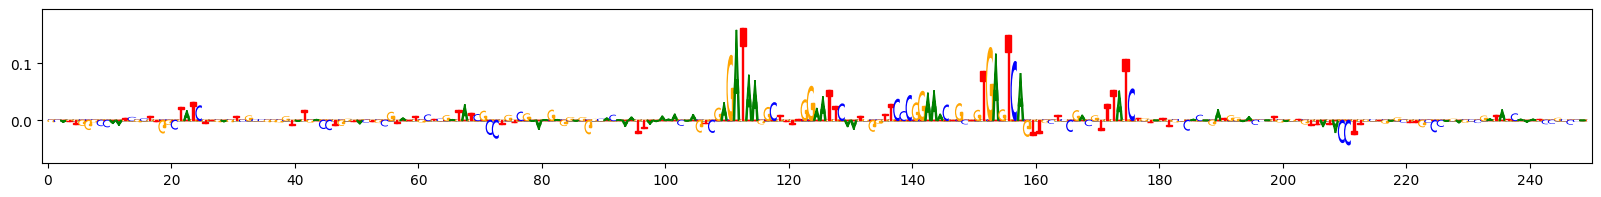

Hk scores
Enhancer: chr2R_14733006_14733254_+_positive_peaks  / Obs Hk act: 1.78  / Pred Hk act: 1.49


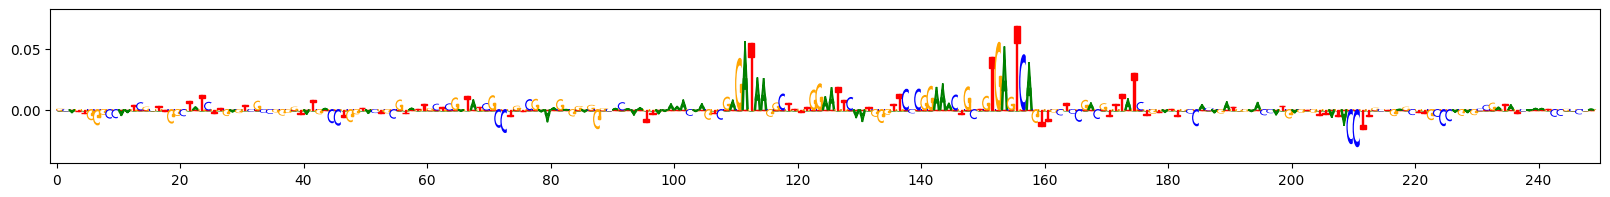


Dev enhancer: chr2R_19400624_19400872_+_positive_peaks
Dev scores
Enhancer: chr2R_19400624_19400872_+_positive_peaks  / Obs Dev act: 6.77  / Pred Dev act: 2.73


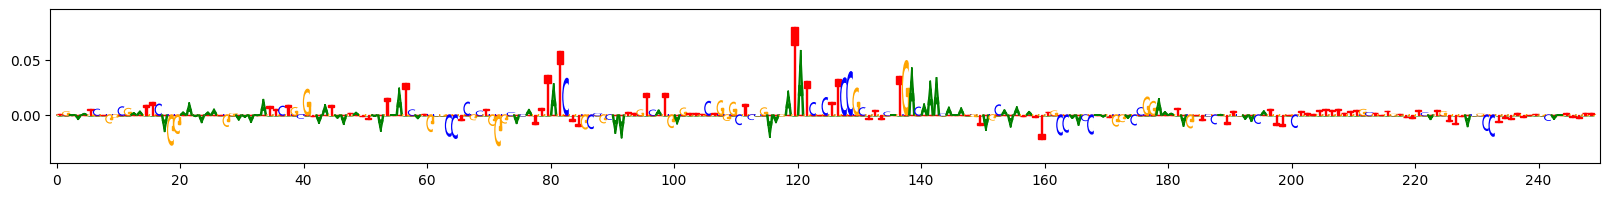

Hk scores
Enhancer: chr2R_19400624_19400872_+_positive_peaks  / Obs Hk act: 1.10  / Pred Hk act: 0.17


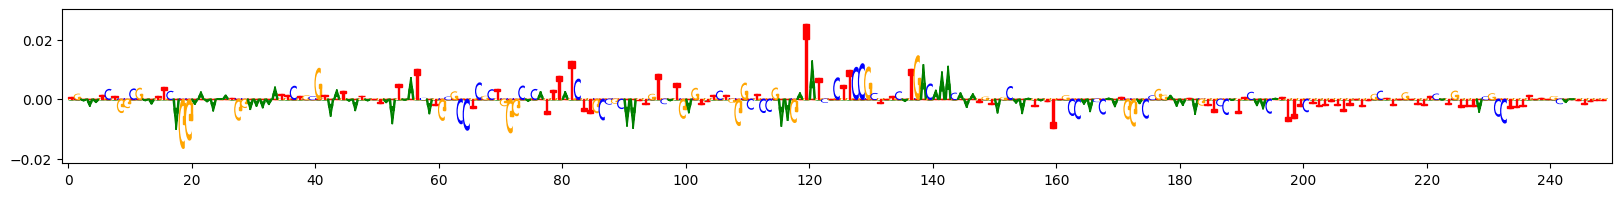


Hk enhancer: chr2R_11681961_11682209_+_positive_peaks
Dev scores
Enhancer: chr2R_11681961_11682209_+_positive_peaks  / Obs Dev act: 0.96  / Pred Dev act: 1.44


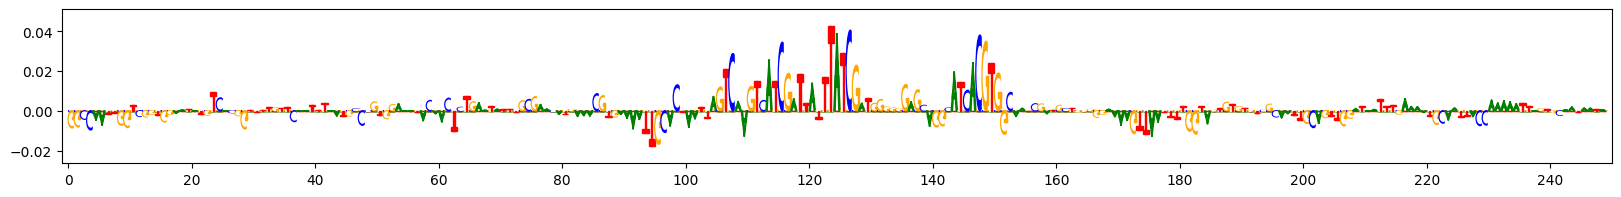

Hk scores
Enhancer: chr2R_11681961_11682209_+_positive_peaks  / Obs Hk act: 4.42  / Pred Hk act: 3.74


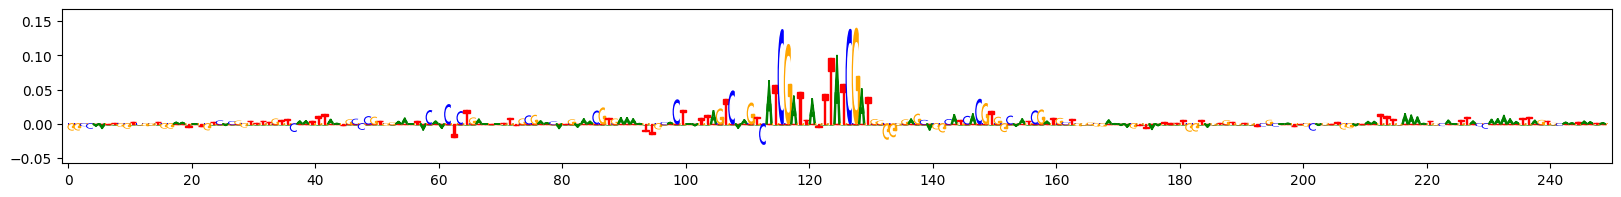


Hk enhancer: chr2R_10823077_10823325_+_positive_peaks
Dev scores
Enhancer: chr2R_10823077_10823325_+_positive_peaks  / Obs Dev act: 0.96  / Pred Dev act: 0.02


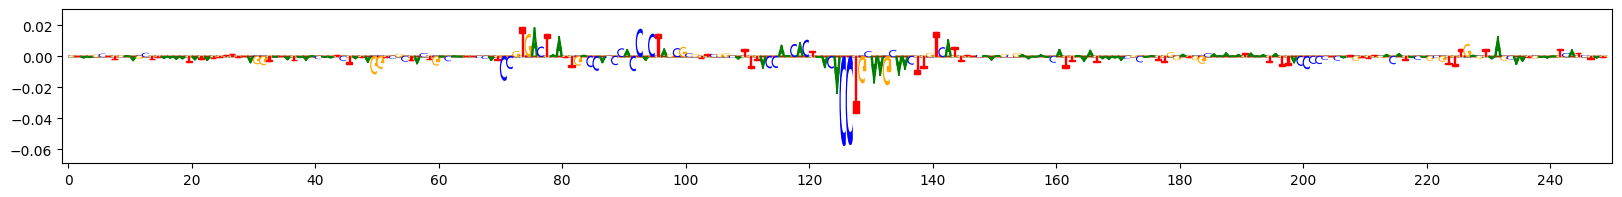

Hk scores
Enhancer: chr2R_10823077_10823325_+_positive_peaks  / Obs Hk act: 3.70  / Pred Hk act: 1.22


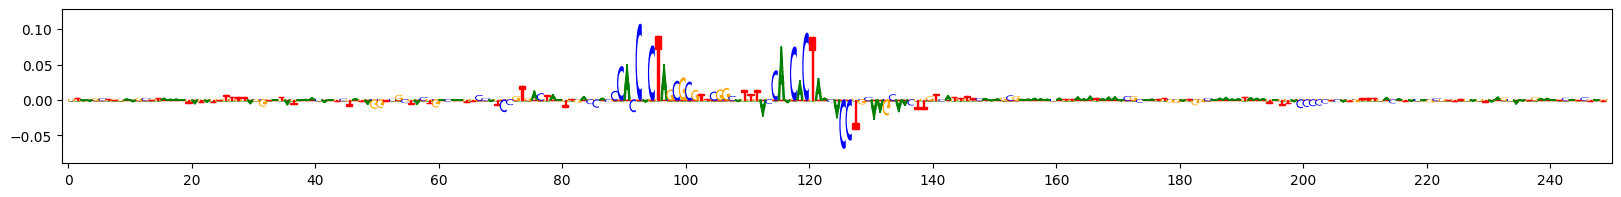

In [ ]:
### Plot scores of some top enhancers - compare dev and hk scores for the same sequence
from deeplift.visualization import viz_sequence # function from https://github.com/kundajelab/deeplift/blob/671ee67a03bd5bebf4c405af59eec45d3ca2a288/deeplift/visualization/viz_sequence.py

for i in [0,4,13,14]:
    enh_type = 'Dev' if cand_specific_enh.iloc[i]['Dev_log2_enrichment'] > cand_specific_enh.iloc[i]['Hk_log2_enrichment'] else 'Hk'
    print()
    print(enh_type, 'enhancer:', cand_specific_enh.iloc[i]['ID'])
    for t in [0,1]: # dev and hk
        enh_class = 'Dev' if t==0 else 'Hk'
        print(enh_class, 'scores')
        print('Enhancer:', cand_specific_enh.iloc[i]['ID'],
              ' / Obs', enh_class, 'act:', '{0:0.2f}'.format(cand_specific_enh.iloc[i][str(enh_class + '_log2_enrichment')]),
              ' / Pred', enh_class, 'act:', '{0:0.2f}'.format(pred_values_both[t].squeeze()[i]))
        viz_sequence.plot_weights(final_contr_scores_both[t][i], figsize=(20,2), subticks_frequency=20)

# Run TF-Modisco to discover motifs

We can use [TF-Modisco](https://github.com/kundajelab/tfmodisco) to systematically discover and summarize recurring highly scoring sequence patterns for each output into motifs, using the contribution scores computed above. For each output, TF–Modisco uses the contribution scores to identify, align and cluster seqlets across all sequences of interest into consolidated motifs. The TF-Modisco algorithm reconstructs less redundant and complete motif representations from the base-resolution contribution scores.  
<img src="https://bernardo-de-almeida.github.io/tutorials/DeepLearning_genomics/Modisco_cartoon.png" alt="modisco dev" width="300"/>

Below are examples of DeepSTARR motifs, generated by TF-Modisco by summarizing recurring predictive sequence patterns from the sequences of all Developmental (left) and Housekeeping (right) enhancers.  

<img src="https://bernardo-de-almeida.github.io/tutorials/DeepLearning_genomics/DeepSTARR_modisco_dev.png" alt="modisco dev" width="300"/>
<img src="https://bernardo-de-almeida.github.io/tutorials/DeepLearning_genomics/DeepSTARR_modisco_hk.jpg" alt="modisco hk" width="300"/>

TF-Modisco needs to be run on an homogeneous group of sequences with similar profiles, in this case either developmental or housekeeping enhancers.

<br></br>
Other possibility to derive motifs would be to look at individual convolutional filters (see examples [here](https://www.nature.com/articles/nbt.3300#Fig6) and [here](https://www.nature.com/articles/s41586-021-04262-z#Fig3)). Each filter in a convolutional layer is designed to detect a specific pattern or feature in the input. By visualizing the filter weights or activations, it is possible to gain insight into the types of patterns that the filter is sensitive to.

## Load model and contribution scores

In [ ]:
# Load the model
# main_model = load_model('my_DeepSTARR_model.h5') # model trained in this notebook
# main_model = load_model('/content/drive/MyDrive/DeepSTARR_tutorial/my_DeepSTARR_model.h5') # model trained in this notebook from google Drive

main_model = load_model('DeepSTARR_model_gw_data.h5') # Final DeepSTARR model from paper, loaded also above

In [ ]:
# Load contribution scores
import h5py

# from google Drive
out = '/content/drive/MyDrive/DeepSTARR_tutorial/my_DeepSTARR_model_contr_scores.h5'
f = h5py.File(out,"r")
tasks = f["contrib_scores"].keys()
print(tasks)

<KeysViewHDF5 ['Dev_contrib_scores', 'Hk_contrib_scores']>


In [ ]:
# You can also load a pre-made contribution scores object if needed
# contr_scores_url = 'https://drive.google.com/uc?id=1SCDbIrKbutpTLxaGFlblndFef34u8MQm' # link to contribution scores object
# contr_scores_path = 'my_DeepSTARR_model_contr_scores.h5'
# gdown.download(contr_scores_url, contr_scores_path, quiet=False)

# import h5py
# f = h5py.File(contr_scores_path,"r")
# tasks = f["contrib_scores"].keys()
# print(tasks)

In [ ]:
# load contribution scores for the developmental and housekeeping enhancers (different tasks)
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()
for task in tasks:
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task]]

f.close()

# load sequence data
import joblib
X_cand_dev = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/X_cand_dev')
X_cand_hk = joblib.load('/content/drive/MyDrive/DeepSTARR_tutorial/X_cand_hk')

In [ ]:
# explore
print('Contribution scores for', len(task_to_scores['Dev_contrib_scores']), 'dev sequences')
print(task_to_scores['Dev_contrib_scores'][0][:6])

print('Hypothetical scores for', len(task_to_hyp_scores['Dev_contrib_scores']), 'dev sequences')
print(task_to_hyp_scores['Dev_contrib_scores'][0][:6])

print('Contribution scores for', len(task_to_scores['Hk_contrib_scores']), 'hk sequences')
print(task_to_scores['Hk_contrib_scores'][0][:6])

print('Hypothetical scores for', len(task_to_hyp_scores['Hk_contrib_scores']), 'hk sequences')
print(task_to_hyp_scores['Hk_contrib_scores'][0][:6])

Contribution scores for 619 dev sequences
[[ 0.          0.         -0.          0.00184663]
 [-0.          0.          0.         -0.00691903]
 [ 0.         -0.          0.          0.00623773]
 [ 0.          0.          0.00139746 -0.        ]
 [-0.00112095 -0.          0.          0.        ]
 [ 0.          0.0022502   0.          0.        ]]
Hypothetical scores for 619 dev sequences
[[ 2.74188901e-03  3.25007699e-04 -8.53453428e-04  1.84662677e-03]
 [-1.47489056e-03  2.74955813e-04  4.05200114e-04 -6.91902645e-03]
 [ 2.06496441e-03 -1.61315671e-03  3.72664378e-03  6.23773158e-03]
 [ 3.61026239e-03  8.50017272e-05  1.39746273e-03 -9.82718023e-05]
 [-1.12095083e-03 -8.82204605e-04  4.75763491e-03  1.97068300e-04]
 [ 2.88662601e-03  2.25019520e-03  1.87412677e-03  5.84873630e-05]]
Contribution scores for 539 hk sequences
[[ 0.          0.          0.         -0.00580285]
 [ 0.         -0.          0.01692693  0.        ]
 [ 0.00387425 -0.          0.          0.        ]
 [ 0.       

## Run TF-Modisco

In [ ]:
# install TF-modisco
!pip install modisco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.3/217.3 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 104.3 MB/s eta 0:00:00
  Created wheel for modisco: filename=modisco-0.5.16.0-py3-none-any.whl size=233642 sha256=232729f548eb1b114ed1b8d46ebc4208f20db2e6d8ac184da6eb1ab1d6ce8add
  Stored in directory: /root/.cache/pip/wheels/8c/86/d3/97d77e5e63de53c3732a39ce129ca4fa5e4dfab8cfe570a145
Successfully built modisco


In [ ]:
import sklearn
print(sklearn.__version__)

1.0.1


In [ ]:
import modisco

# check parameters
import inspect
def get_default_args(func):
    signature = inspect.signature(func)
    return {
        k: v.default
        for k, v in signature.parameters.items()
        if v.default is not inspect.Parameter.empty
    }

get_default_args(modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow)

{'seqlets_to_patterns_factory': <modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory at 0x7f563cbc0880>,
 'sliding_window_size': 21,
 'flank_size': 10,
 'overlap_portion': 0.5,
 'min_metacluster_size': 100,
 'min_metacluster_size_frac': 0.01,
 'weak_threshold_for_counting_sign': 0.8,
 'max_seqlets_per_metacluster': 20000,
 'target_seqlet_fdr': 0.2,
 'min_passing_windows_frac': 0.03,
 'max_passing_windows_frac': 0.2,
 'separate_pos_neg_thresholds': False,
 'verbose': True,
 'min_seqlets_per_task': None}

### TF-Modisco function

In [ ]:
from importlib import reload
# reload(modisco.util)
# reload(modisco.pattern_filterer)
# reload(modisco.aggregator)
# reload(modisco.core)
# reload(modisco.seqlet_embedding.advanced_gapped_kmer)
# reload(modisco.affinitymat.transformers)
# reload(modisco.affinitymat.core)
# reload(modisco.affinitymat)
# reload(modisco.cluster.core)
# reload(modisco.cluster)
# reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
# reload(modisco.tfmodisco_workflow)
# reload(modisco)

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)

# prepare TF-modisco function to run for dev or hk
def my_tfmodisco(task):

    # which sequences to use
    if task == 'Dev_contrib_scores': one_hot = X_cand_dev
    if task == 'Hk_contrib_scores': one_hot = X_cand_hk

    tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                        #target_seqlet_fdr controls the stringency of the threshold used.
                        # the default value is 0.2
                        target_seqlet_fdr=0.2,
                        #min_passing_windows_frac and max_passing_windows_frac can be used
                        # to manually adjust the percentile cutoffs for importance
                        # scores if you feel that the cutoff
                        # defined by the null distribution is too stringent or too
                        # lenient. The default values are 0.03 and 0.2 respectively.
                        #min_passing_windows_frac=0.03,
                        #max_passing_windows_frac=0.2
                        #The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks.
                        #If the window size or flank sizes are too long, you risk picking up more noise.
                        sliding_window_size=15,
                        flank_size=5,
                        max_seqlets_per_metacluster=50000,
                        seqlets_to_patterns_factory=
                            modisco.tfmodisco_workflow
                                    .seqlets_to_patterns
                                    .TfModiscoSeqletsToPatternsFactory(
                                #kmer_len, num_gaps and num_mismatches are used to
                                # derive kmer embeddings for coarse-grained affinity
                                # matrix calculation. kmer_len=6, num_gaps=1
                                # and num_mismatches=0 means
                                # that kmer embeddings using 6-mers with 1 gap will be
                                # used. The default is to use longer kmers, but this
                                # can take a while to run and can lead to
                                # out-of-memory errors on some systems.
                                # Empirically, 6-mers with 1-gap
                                # seem to give good results.
                                #During the seqlet clustering, motifs are trimmed to the central trim_to_window_size bp with the highest importance
                                trim_to_window_size=15,
                                #After the trimming is done, the seqlet is expanded on either side by initial_flank_to_add
                                initial_flank_to_add=5,
                                final_min_cluster_size=30
                        )
                   )(
                task_names=[task],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=one_hot,
                null_per_pos_scores = null_per_pos_scores)

    return tfmodisco_results


### Function to visualize TF-modisco motifs

In [ ]:
# function to visualize motifs
from collections import Counter
import numpy as np

from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

def modisco_motif_plots(task):

    # Load results
    if task == 'Dev_contrib_scores': hdf5_results = h5py.File("/content/drive/MyDrive/DeepSTARR_tutorial/Dev_modisco_results.hdf5","r") # from Google Drive
    if task == 'Hk_contrib_scores': hdf5_results = h5py.File("/content/drive/MyDrive/DeepSTARR_tutorial/Hk_modisco_results.hdf5","r") # from Google Drive

    metacluster_names = [
        x.decode("utf-8") for x in
        list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])]

    all_patterns = []


    if task == 'Dev_contrib_scores': background = np.mean(X_cand_dev, axis=(0,1))
    if task == 'Hk_contrib_scores': background = np.mean(X_cand_hk, axis=(0,1))

    # sequence background
    if task == 'Dev_contrib_scores': background = np.mean(X_cand_dev, axis=(0,1))
    if task == 'Hk_contrib_scores': background = np.mean(X_cand_hk, axis=(0,1))

    for metacluster_name in metacluster_names:
        print(metacluster_name)
        metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                       [metacluster_name])
        print("activity pattern:",metacluster_grp["activity_pattern"][:])
        all_pattern_names = [x.decode("utf-8") for x in
                             list(metacluster_grp["seqlets_to_patterns_result"]
                                                 ["patterns"]["all_pattern_names"][:])]
        if (len(all_pattern_names)==0):
            print("No motifs found for this activity pattern")
        for pattern_name in all_pattern_names:
            print(metacluster_name, pattern_name)
            all_patterns.append((metacluster_name, pattern_name))
            pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
            print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
            # print("Actual importance scores:")
            # viz_sequence.plot_weights(pattern[str(task + "_contrib_scores")]["fwd"])
            # print("Hypothetical scores:")
            # viz_sequence.plot_weights(pattern[str(task + "_hypothetical_contribs")]["fwd"])
            print("IC-scaled, fwd and rev:")
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                            background=background))
            viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                            background=background))

            #Plot the subclustering too, if available
            if ("subclusters" in pattern):
                print("PLOTTING SUBCLUSTERS")
                subclusters = np.array(pattern["subclusters"])
                twod_embedding = np.array(pattern["twod_embedding"])
                plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
                plt.show()
                for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
                    subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
                    print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
                    subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
                    plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
                    plt.show()
                    # viz_sequence.plot_weights(subpattern[str(task + "_hypothetical_contribs")]["fwd"])
                    # viz_sequence.plot_weights(subpattern[str(task + "_contrib_scores")]["fwd"])
                    viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(subpattern["sequence"]["fwd"]),
                                                            background=background))

    hdf5_results.close()

## Developmental enhancers

Below we visualize the main motifs discovered by TF-modisco (metaclusters). For each I am showing also the different motif variants in their sub-sclusters (computed from the t-SNE plot).

These motifs were created from a small subset of enhancers to be faster. Ideally we would run on all developmental or housekeeping enhancers.

In [ ]:
# Run TF-Modisco - takes around 10mins
dev_tfmodisco_results = my_tfmodisco('Dev_contrib_scores')

# save results
import modisco.util
reload(modisco.util)
grp = h5py.File("/content/drive/MyDrive/DeepSTARR_tutorial/Dev_modisco_results.hdf5", "w") # on Google Drive
dev_tfmodisco_results.save_hdf5(grp)
grp.close()

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 108
IC-scaled, fwd and rev:


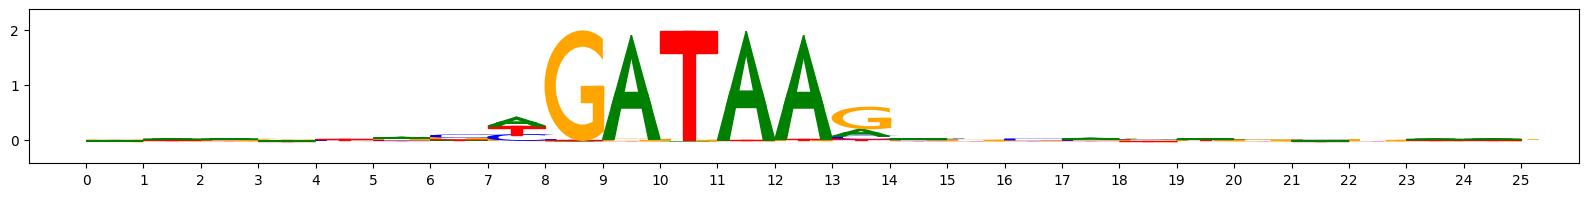

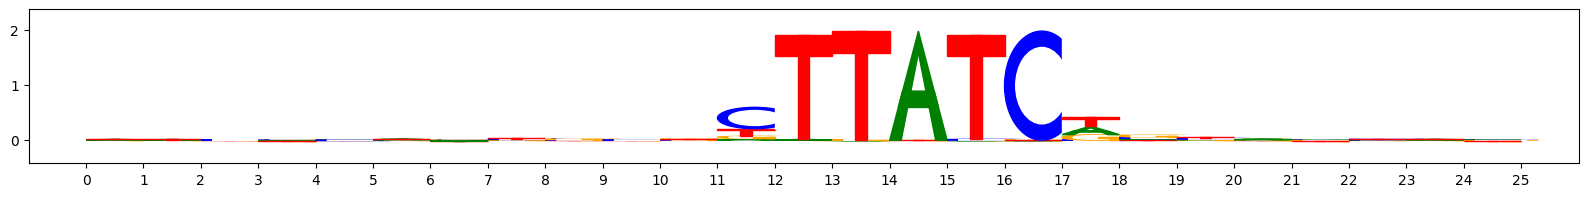

PLOTTING SUBCLUSTERS


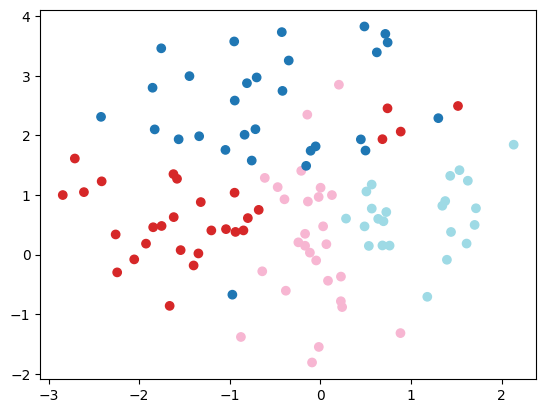

subcluster_1 size 29


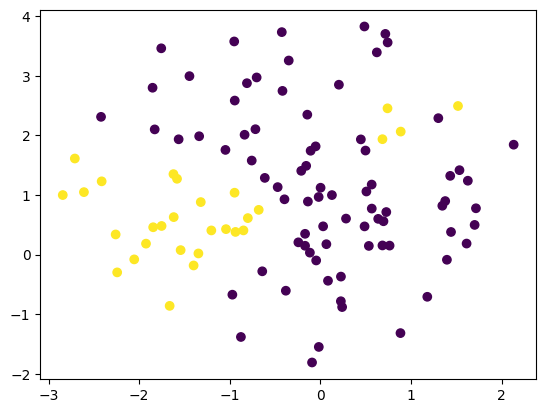

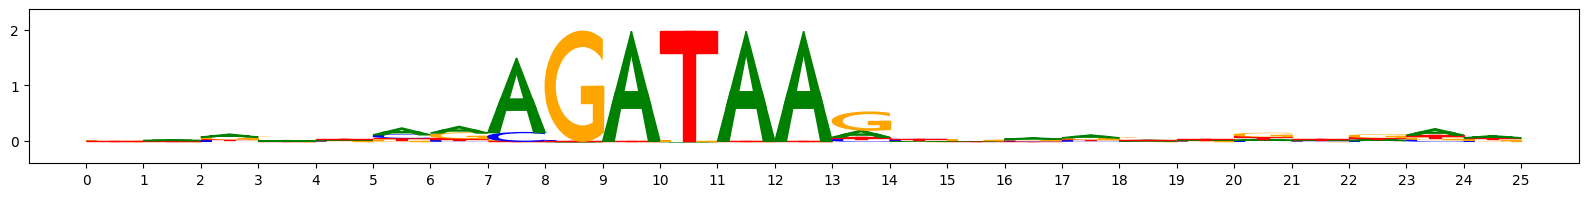

subcluster_0 size 29


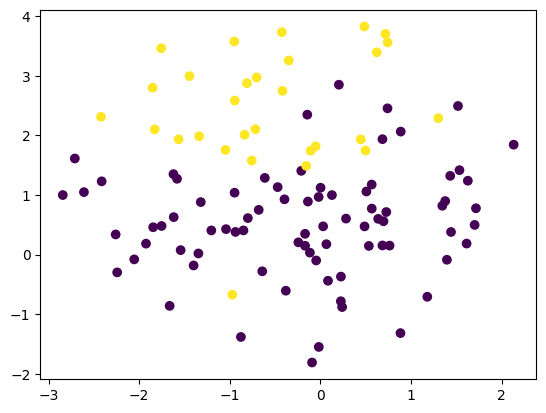

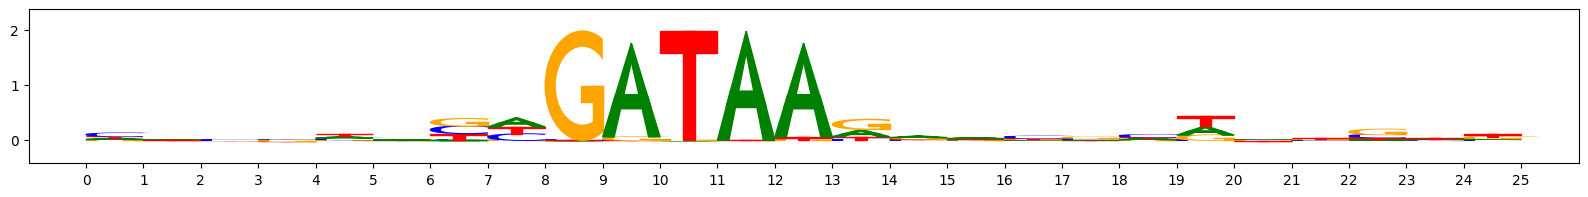

subcluster_2 size 27


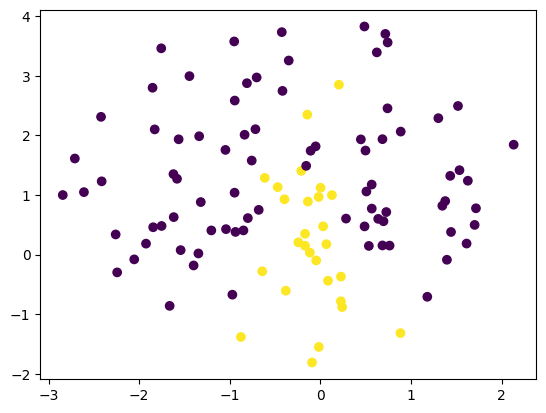

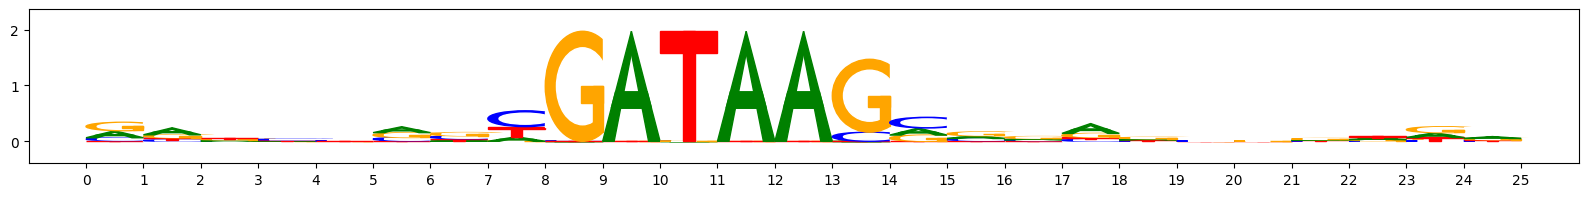

subcluster_3 size 23


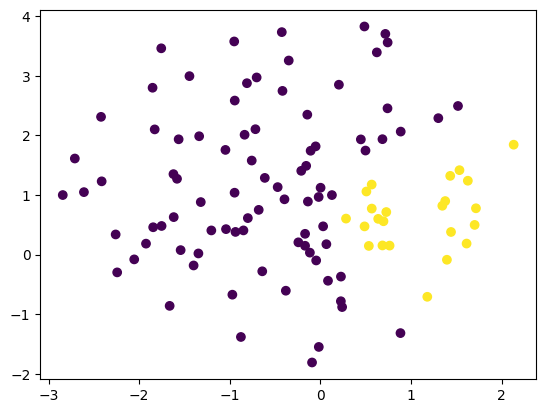

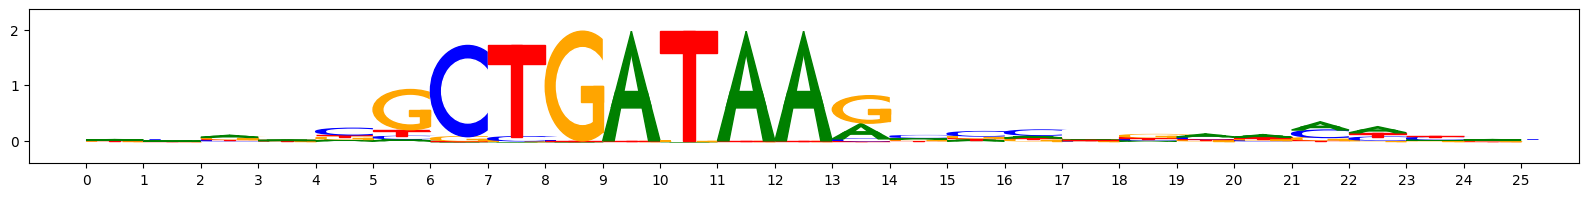

metacluster_0 pattern_1
total seqlets: 105
IC-scaled, fwd and rev:


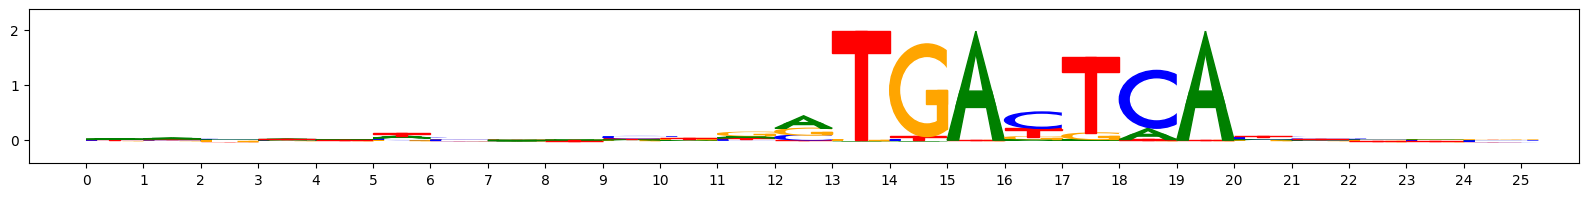

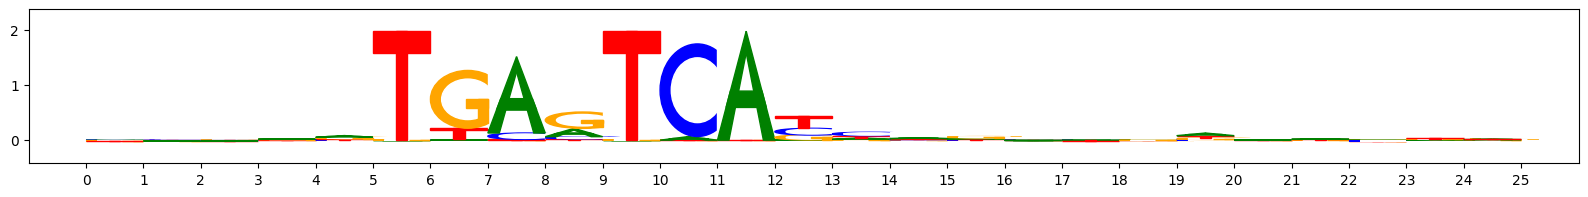

PLOTTING SUBCLUSTERS


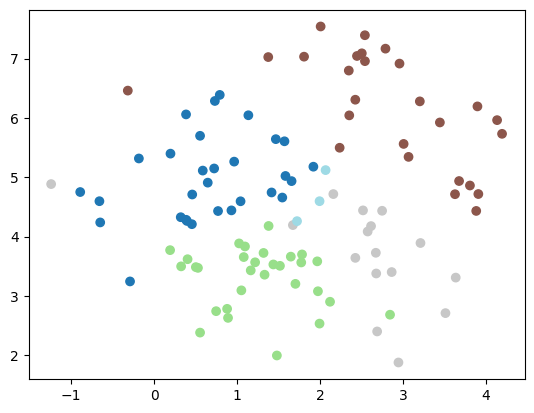

subcluster_1 size 30


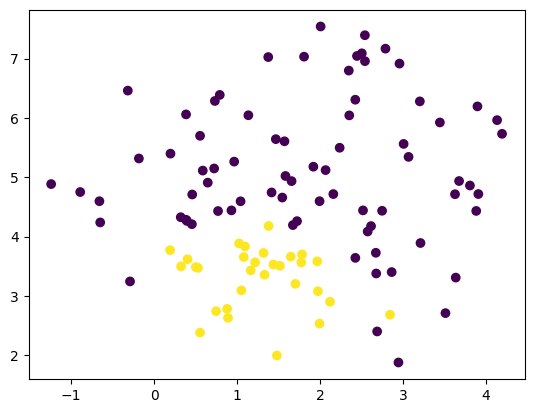

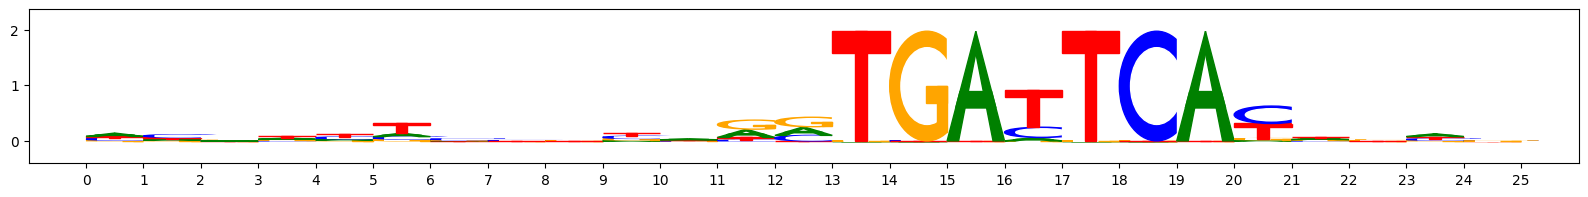

subcluster_0 size 30


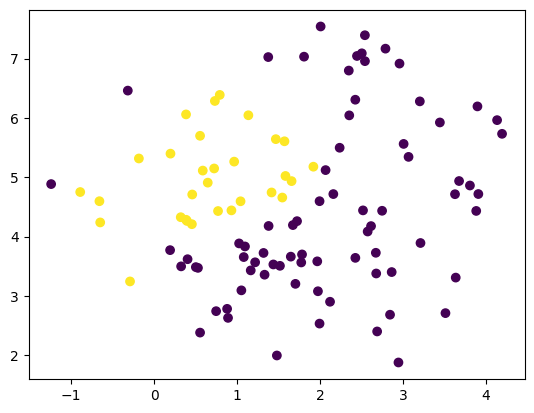

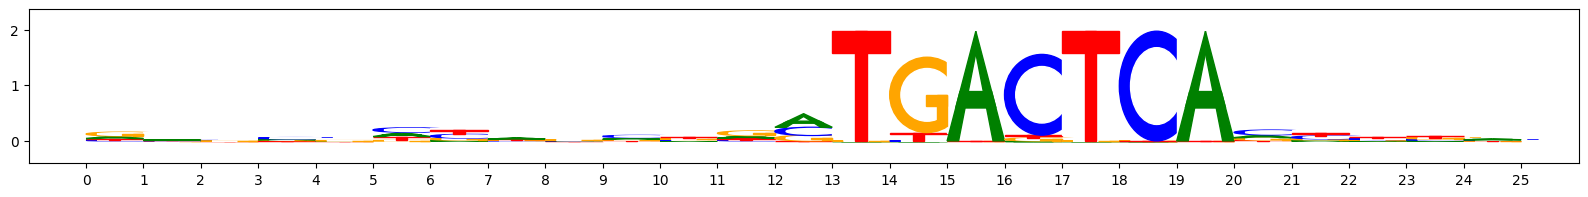

subcluster_2 size 26


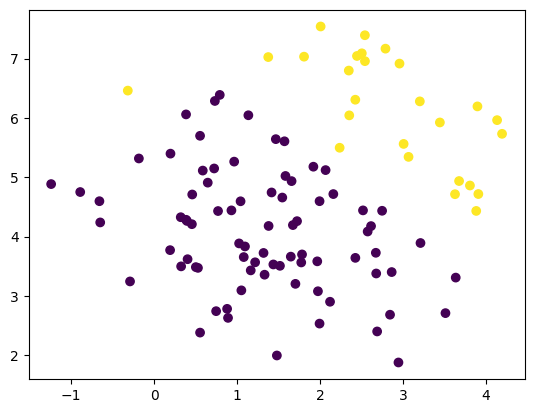

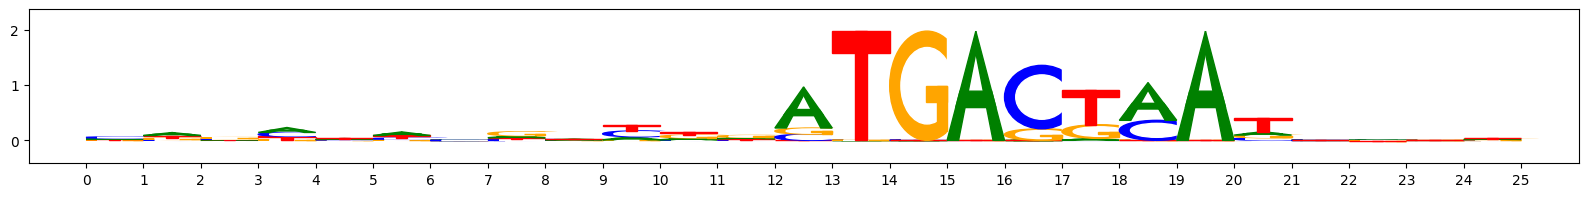

subcluster_3 size 16


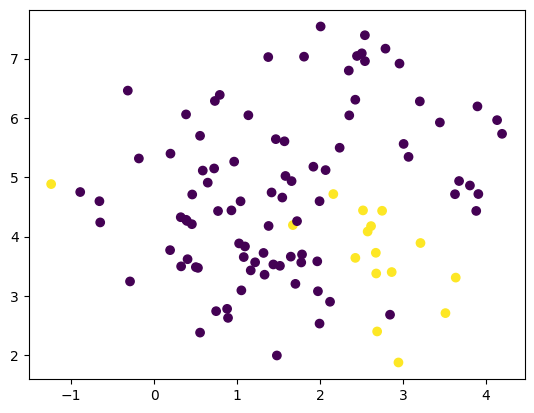

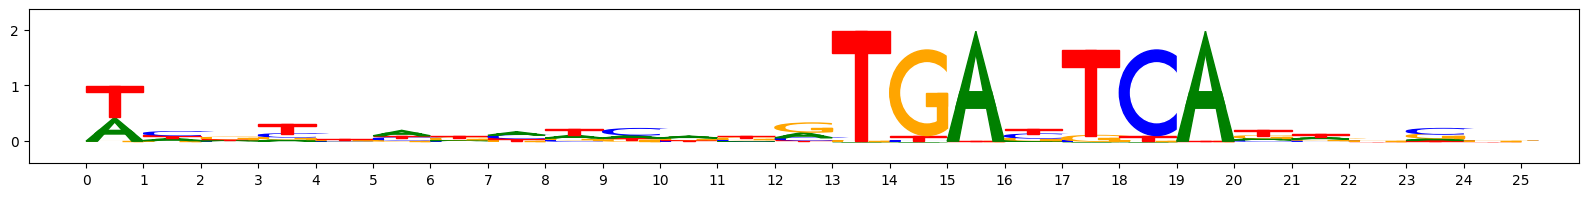

subcluster_4 size 3


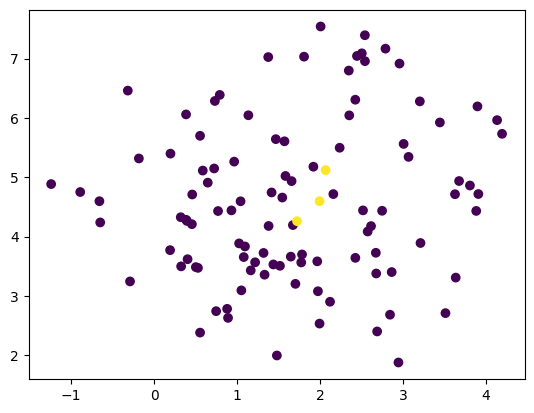

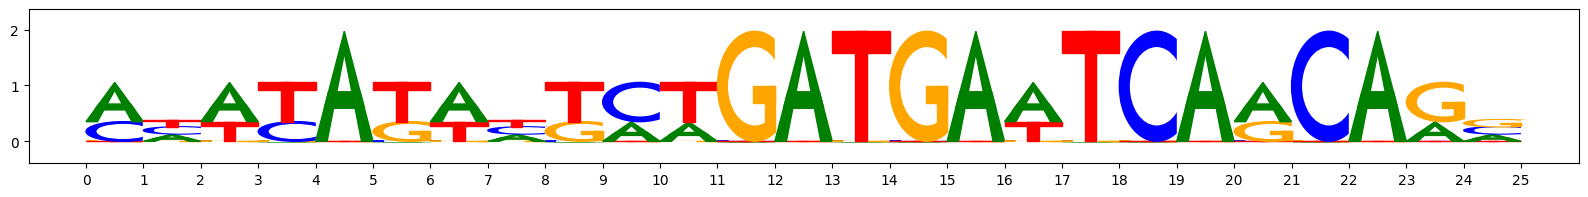

metacluster_0 pattern_2
total seqlets: 64
IC-scaled, fwd and rev:


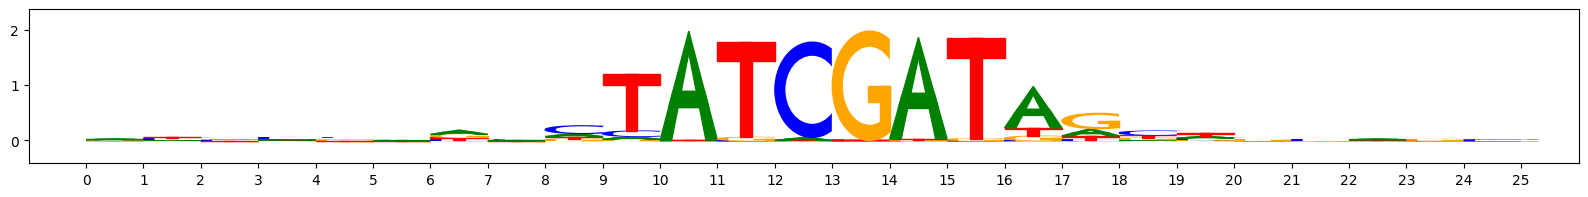

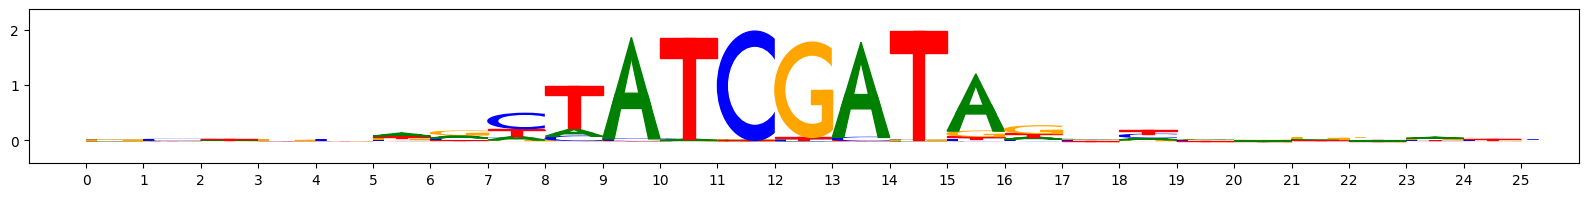

PLOTTING SUBCLUSTERS


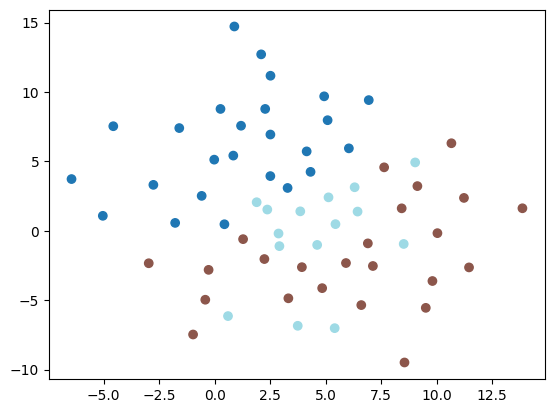

subcluster_0 size 25


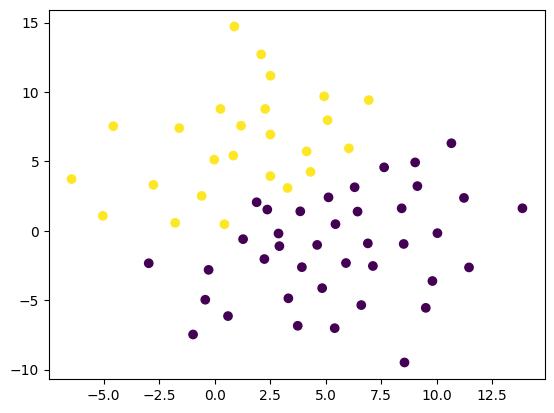

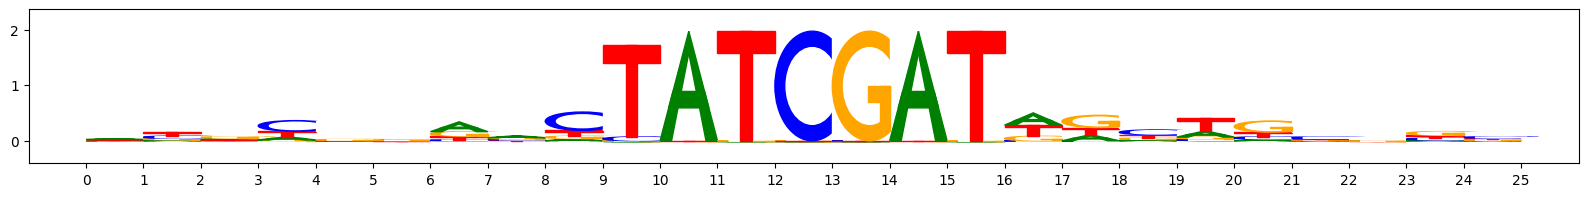

subcluster_1 size 24


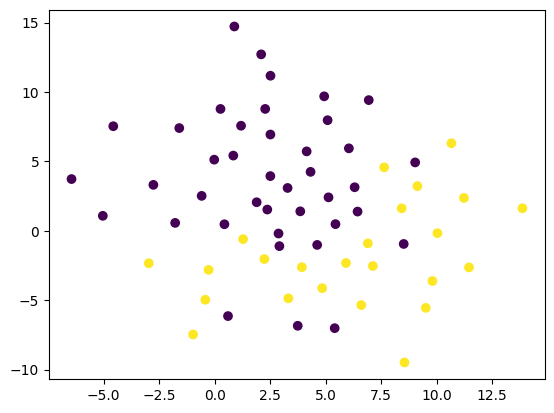

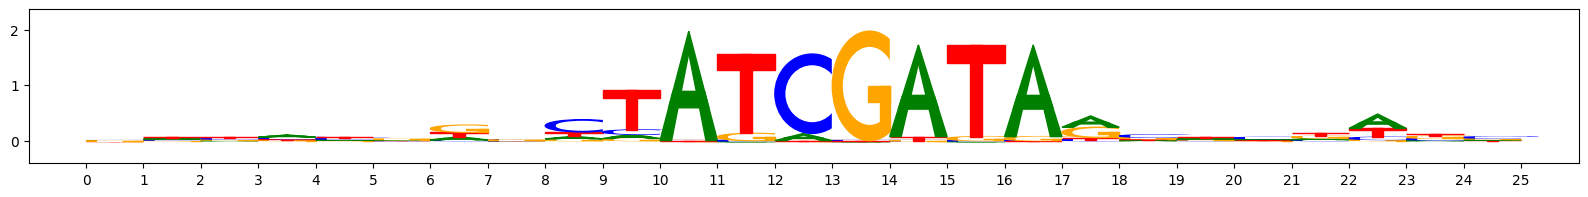

subcluster_2 size 15


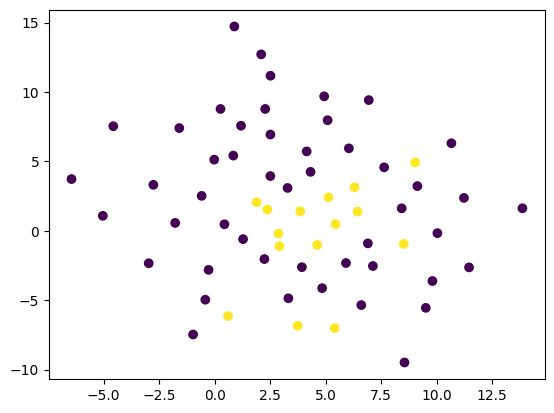

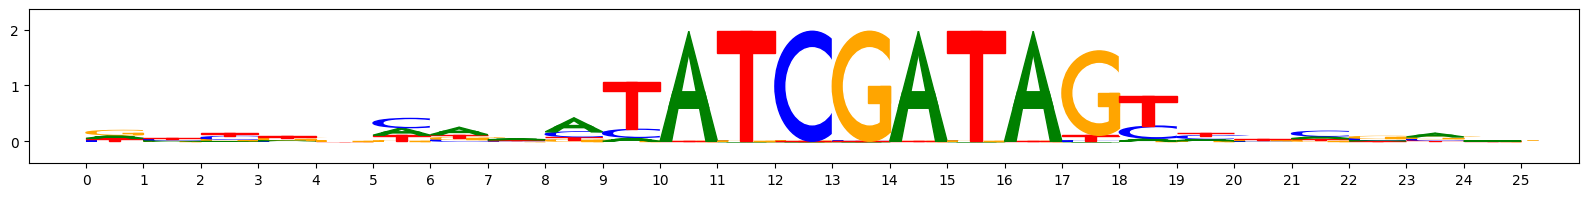

metacluster_0 pattern_3
total seqlets: 44
IC-scaled, fwd and rev:


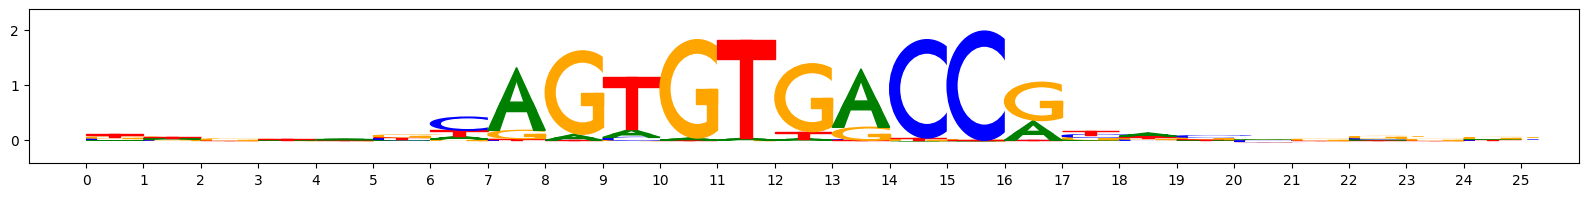

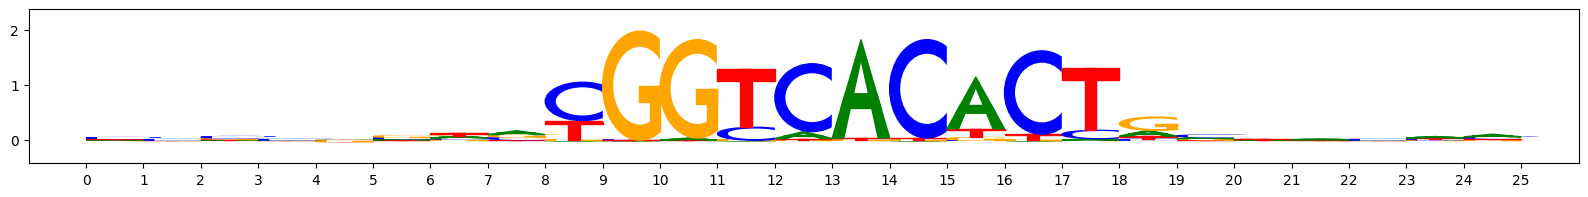

PLOTTING SUBCLUSTERS


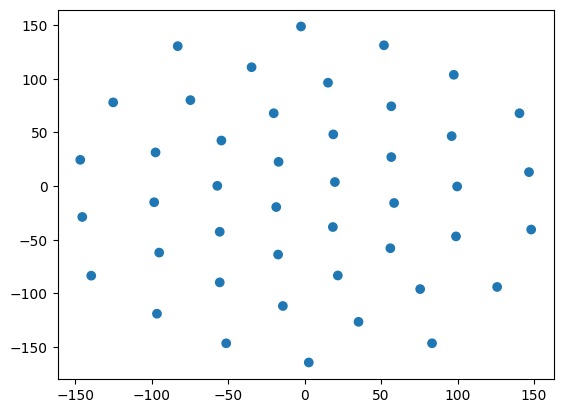

subcluster_0 size 44


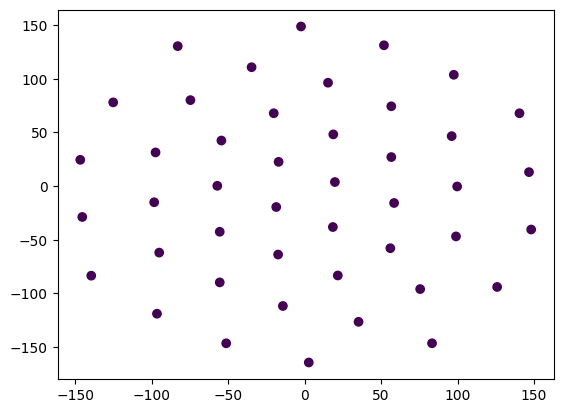

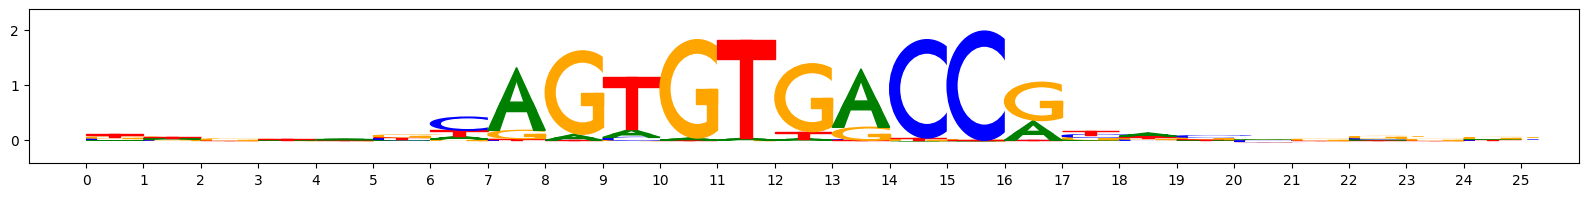

In [ ]:
# Visualize motifs
modisco_motif_plots('Dev_contrib_scores')

## Housekeeping enhancers

MEMORY 2.947760128
On task Hk_contrib_scores
Computing windowed sums on original
Generating null dist
peak(mu)= -0.002933447664324299
Computing threshold
For increasing = True , the minimum IR precision was 0.10335307298335467 occurring at 1.1314280272678445e-06 implying a frac_neg of 0.115266187692445
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4438860302635534 occurring at -5.931368432313122e-07 implying a frac_neg of 0.7981925547993691
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.38680540455495066  and  0.3902959737273486 with frac passing 0.06835353096751273
Final raw thresholds are -0.38680540455495066  and  0.3902959737273486
Final transformed thresholds are -0.9308727746417716  and  0.9316622587139305


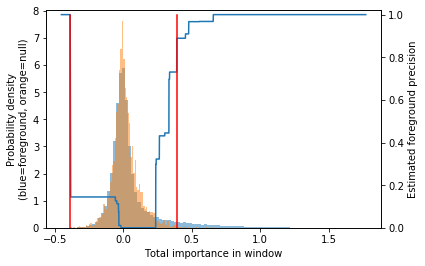

Got 680 coords
After resolving overlaps, got 680 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9307727746417717
MEMORY 2.950782976
680 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [675]
Idx to activities:  {0: '1'}
MEMORY 2.950782976
On metacluster 0
Metacluster size 675
Relevant tasks:  ('Hk_contrib_scores',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 675
(Round 1) Computing coarse affmat
MEMORY 2.950782976
Beginning embedding computation
MEMORY 2.950782976


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   32.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 675 out of 675 | elapsed:  1.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   29.0s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 675 out of 675 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.0975184440612793 s


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:    1.3s finished


Constructing csr matrix...
csr matrix made in 0.0909719467163086 s
Finished embedding computation in 213.8 s
MEMORY 3.00822528
Starting affinity matrix computations
MEMORY 3.00822528
Batching in slices of size 675


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

Finished affinity matrix computations in 2.1 s
MEMORY 3.02280704
(Round 1) Computed coarse affmat
MEMORY 3.0201856
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 3.0201856


Launching nearest neighbors affmat calculation job
MEMORY 3.0201856
Parallel runs completed
MEMORY 3.026673664
Job completed in: 7.65 s
MEMORY 3.02641152
Launching nearest neighbors affmat calculation job
MEMORY 3.02641152
Parallel runs completed
MEMORY 3.02641152
Job completed in: 7.67 s
MEMORY 3.02641152
(Round 1) Computed affinity matrix on nearest neighbors in 15.61 s
MEMORY 3.02641152
Filtered down to 673 of 675
(Round 1) Retained 673 rows out of 675 after filtering
MEMORY 3.02641152
(Round 1) Computing density adapted affmat
MEMORY 3.02641152
[t-SNE] Computed conditional probabilities for sample 673 / 673
[t-SNE] Mean sigma: 0.217920
(Round 1) Computing clustering
MEMORY 3.02641152
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7170934647607925
Quality: 0.7206469581652435


 80%|████████  | 40/50 [00:01<00:00, 33.13it/s]

Quality: 0.7207228915234803


100%|██████████| 50/50 [00:01<00:00, 31.71it/s]

Got 14 clusters after round 1
Counts:
{1: 96, 3: 63, 5: 51, 0: 146, 10: 16, 12: 10, 13: 7, 4: 61, 11: 15, 2: 78, 8: 29, 6: 41, 9: 25, 7: 35}
MEMORY 3.02641152
(Round 1) Aggregating seqlets in each cluster
MEMORY 3.02641152
Aggregating for cluster 0 with 146 seqlets
MEMORY 3.02641152


Trimming eliminated 0 seqlets out of 146
Skipped 1 seqlets
Aggregating for cluster 1 with 96 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 96
Skipped 1 seqlets
Aggregating for cluster 2 with 78 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 78
Removed 1 duplicate seqlets
Aggregating for cluster 3 with 63 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 63
Skipped 1 seqlets
Aggregating for cluster 4 with 61 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 61
Skipped 1 seqlets
Aggregating for cluster 5 with 51 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 51
Removed 1 duplicate seqlets
Aggregating for cluster 6 with 41 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 41
Aggregating for cluster 7 with 35 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 35
Aggregating for cluster 8 with 29 seqlets
MEMORY 3.02641152
Trimming eliminated 0 seqlets out of 29
Aggregating for cluster 9 with 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   27.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 665 out of 665 | elapsed:  1.6min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   27.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 665 out of 665 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Constructing csr matrix...
csr matrix made in 0.0989065170288086 s


[Parallel(n_jobs=1)]: Done 665 out of 665 | elapsed:    1.3s finished


Constructing csr matrix...
csr matrix made in 0.08816766738891602 s
Finished embedding computation in 199.49 s
MEMORY 3.049422848
Starting affinity matrix computations
MEMORY 3.049422848
Batching in slices of size 665


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

Finished affinity matrix computations in 2.05 s
MEMORY 3.055312896
(Round 2) Computed coarse affmat
MEMORY 3.053215744
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 3.053215744


Launching nearest neighbors affmat calculation job
MEMORY 3.053215744
Parallel runs completed
MEMORY 3.052691456
Job completed in: 7.58 s
MEMORY 3.052429312
Launching nearest neighbors affmat calculation job
MEMORY 3.052429312
Parallel runs completed
MEMORY 3.060097024
Job completed in: 7.45 s
MEMORY 3.060097024
(Round 2) Computed affinity matrix on nearest neighbors in 15.32 s
MEMORY 3.060097024
Not applying filtering for rounds above first round
MEMORY 3.060097024
(Round 2) Computing density adapted affmat
MEMORY 3.060097024
[t-SNE] Computed conditional probabilities for sample 665 / 665
[t-SNE] Mean sigma: 0.220027
(Round 2) Computing clustering
MEMORY 3.05983488
Beginning preprocessing + Leiden


  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7285882359321052
Quality: 0.7299238092679332


100%|██████████| 50/50 [00:01<00:00, 31.00it/s]

Got 12 clusters after round 2
Counts:
{0: 176, 4: 58, 6: 39, 5: 41, 1: 95, 2: 67, 11: 8, 3: 66, 7: 39, 8: 29, 10: 22, 9: 25}
MEMORY 3.05983488
(Round 2) Aggregating seqlets in each cluster
MEMORY 3.05983488
Aggregating for cluster 0 with 176 seqlets
MEMORY 3.05983488


Trimming eliminated 0 seqlets out of 176
Aggregating for cluster 1 with 95 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 95
Aggregating for cluster 2 with 67 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 67
Aggregating for cluster 3 with 66 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 66
Aggregating for cluster 4 with 58 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 58
Removed 6 duplicate seqlets
Aggregating for cluster 5 with 41 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 41
Aggregating for cluster 6 with 39 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 39
Removed 3 duplicate seqlets
Aggregating for cluster 7 with 39 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 39
Aggregating for cluster 8 with 29 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 29
Aggregating for cluster 9 with 25 seqlets
MEMORY 3.05983488
Trimming eliminated 0 seqlets out of 25
Agg

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 250 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 303 out of 303 | elapsed:    0.5s finished
/users/bernardo.almeida/miniconda3/envs/DeepLearning_conda_env_gpu_deepshap/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
/users/bernardo.almeida/miniconda3/envs/DeepLearning_conda_env_gpu_deepshap/lib/python3.7/site-packages/sklearn/neighbors/_base.py:176: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 303 samples in 0.002s...
[t-SNE] Computed neighbors for 303 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 303 / 303
[t-SNE] Mean sigma: 0.280592
[t-SNE] Computed conditional probabilities in 0.014s
[t-SNE] Iteration 50: error = 75.9866943, gradient norm = 0.4581409 (50 iterations in 0.097s)
[t-SNE] Iteration 100: error = 73.8792877, gradient norm = 0.4538023 (50 iterations in 0.108s)
[t-SNE] Iteration 150: error = 75.8526382, gradient norm = 0.4457851 (50 iterations in 0.092s)
[t-SNE] Iteration 200: error = 73.8351440, gradient norm = 0.4671805 (50 iterations in 0.092s)
[t-SNE] Iteration 250: error = 76.3216629, gradient norm = 0.4323780 (50 iterations in 0.096s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.321663
[t-SNE] Iteration 300: error = 1.4123890, gradient norm = 0.0074830 (50 iterations in 0.079s)
[t-SNE] Iteration 350: error = 1.2827990, gradient norm = 0.0020783 (

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3893174610238858


  8%|▊         | 4/50 [00:00<00:01, 34.44it/s]

Quality: 0.3893623287213933


100%|██████████| 50/50 [00:01<00:00, 27.76it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


On pattern 1
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 196 samples in 0.001s...
[t-SNE] Computed neighbors for 196 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 196 / 196
[t-SNE] Mean sigma: 0.285834
[t-SNE] Computed conditional probabilities in 0.009s


[Parallel(n_jobs=4)]: Done 196 out of 196 | elapsed:    0.2s finished


[t-SNE] Iteration 50: error = 73.1200943, gradient norm = 0.4728582 (50 iterations in 0.057s)
[t-SNE] Iteration 100: error = 69.1863098, gradient norm = 0.4653544 (50 iterations in 0.053s)
[t-SNE] Iteration 150: error = 67.1187592, gradient norm = 0.5487725 (50 iterations in 0.055s)
[t-SNE] Iteration 200: error = 71.7826233, gradient norm = 0.4032085 (50 iterations in 0.058s)
[t-SNE] Iteration 250: error = 66.9526749, gradient norm = 0.4877805 (50 iterations in 0.055s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.952675
[t-SNE] Iteration 300: error = 1.1114227, gradient norm = 0.0067889 (50 iterations in 0.051s)
[t-SNE] Iteration 350: error = 0.8703833, gradient norm = 0.0067063 (50 iterations in 0.051s)
[t-SNE] Iteration 400: error = 0.8127195, gradient norm = 0.0020321 (50 iterations in 0.052s)
[t-SNE] Iteration 450: error = 0.7679561, gradient norm = 0.0036382 (50 iterations in 0.052s)
[t-SNE] Iteration 500: error = 0.7112464, gradient norm = 0.0024809 (50 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.38196250917987823
Quality: 0.3832068942164836


100%|██████████| 50/50 [00:00<00:00, 51.59it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 101 out of 101 | elapsed:    0.1s finished


On pattern 2
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 101 samples in 0.001s...
[t-SNE] Computed neighbors for 101 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 101 / 101
[t-SNE] Mean sigma: 0.364291
[t-SNE] Computed conditional probabilities in 0.005s
[t-SNE] Iteration 50: error = 61.1968994, gradient norm = 0.5309877 (50 iterations in 0.024s)
[t-SNE] Iteration 100: error = 61.4086952, gradient norm = 0.4600768 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 59.2416916, gradient norm = 0.4810503 (50 iterations in 0.027s)
[t-SNE] Iteration 200: error = 59.9327240, gradient norm = 0.5285664 (50 iterations in 0.025s)
[t-SNE] Iteration 250: error = 62.1967392, gradient norm = 0.4753110 (50 iterations in 0.026s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.196739
[t-SNE] Iteration 300: error = 0.9558578, gradient norm = 0.0060546 (50 iterations in 0.024s)
[t-SNE] Iteration 350: error = 0.8418183, gradient norm 

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.3354406935302732


100%|██████████| 50/50 [00:00<00:00, 177.72it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:    0.0s finished


On pattern 3
[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Indexed 48 samples in 0.001s...
[t-SNE] Computed neighbors for 48 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 0.495552
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 48.2227821, gradient norm = 0.7373189 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 49.8755569, gradient norm = 0.5346367 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 51.8228951, gradient norm = 0.4389585 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 49.6470375, gradient norm = 0.5184004 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 47.7706070, gradient norm = 0.6027185 (50 iterations in 0.012s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.770607
[t-SNE] Iteration 300: error = 1.0724220, gradient norm = 0.0013712 (50 iterations in 0.012s)
[t-SNE] Iteration 350: error = 0.8740886, gradient norm = 0.

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.13911982988916582
Quality: 0.14166728608440057


100%|██████████| 50/50 [00:00<00:00, 681.59it/s]


In [ ]:
# Run TF-Modisco - takes around 10mins
hk_tfmodisco_results = my_tfmodisco('Hk_contrib_scores')

# save results
import modisco.util
reload(modisco.util)
grp = h5py.File("/content/drive/MyDrive/DeepSTARR_tutorial/Hk_modisco_results.hdf5", "w") # on Google Drive
hk_tfmodisco_results.save_hdf5(grp)
grp.close()

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 303
IC-scaled, fwd and rev:


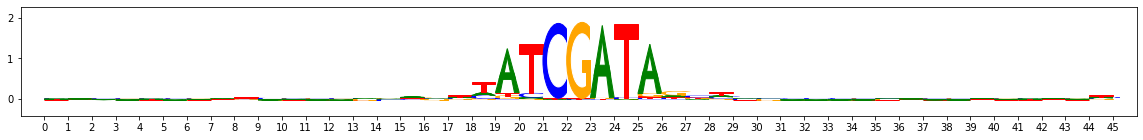

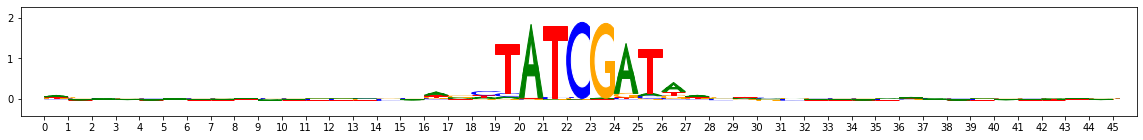

PLOTTING SUBCLUSTERS


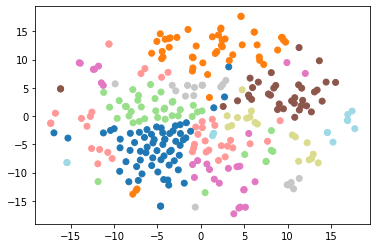

subcluster_0 size 64


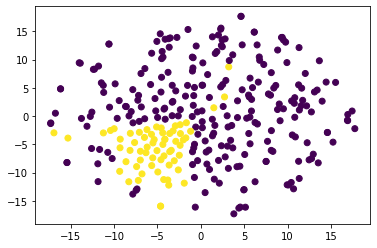

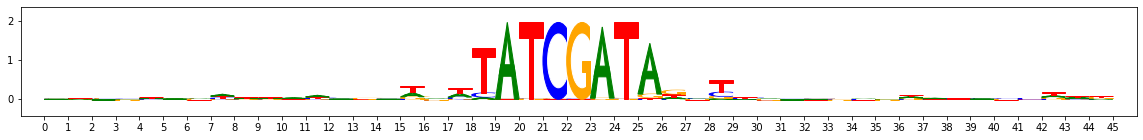

subcluster_1 size 49


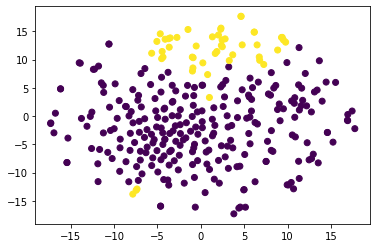

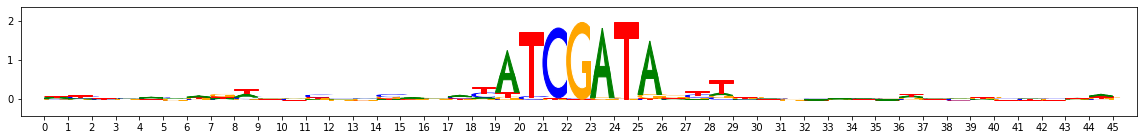

subcluster_2 size 40


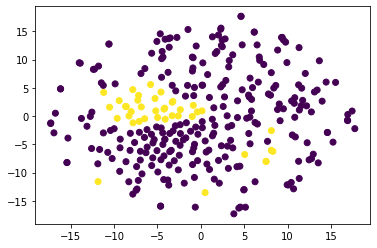

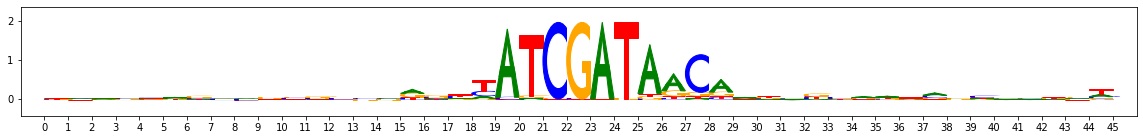

subcluster_3 size 39


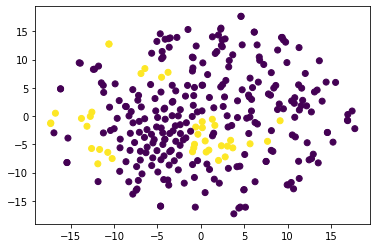

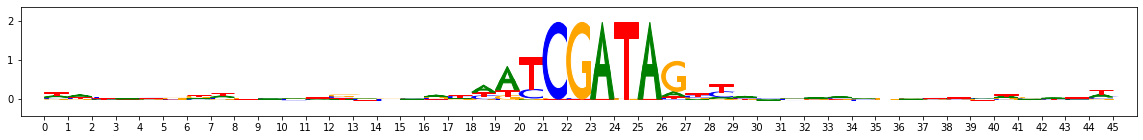

subcluster_4 size 36


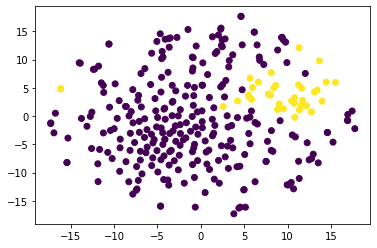

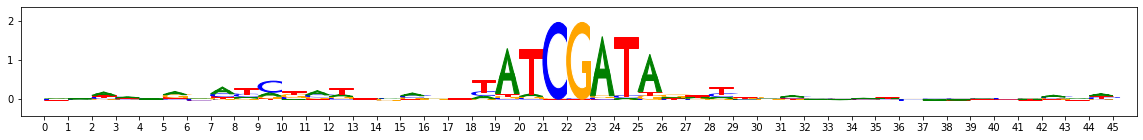

subcluster_5 size 27


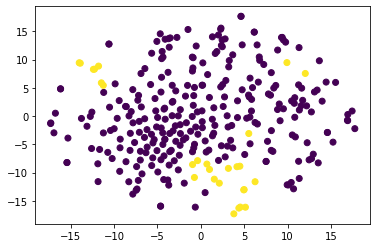

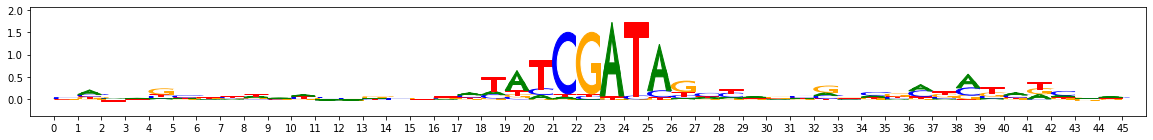

subcluster_7 size 18


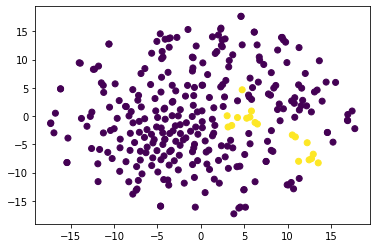

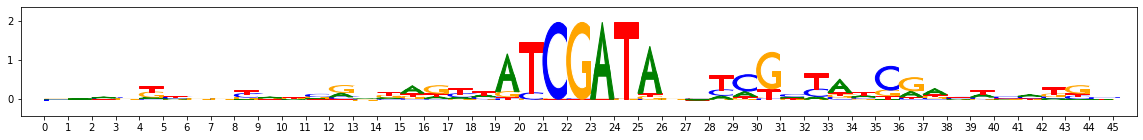

subcluster_6 size 18


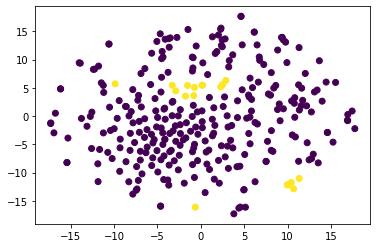

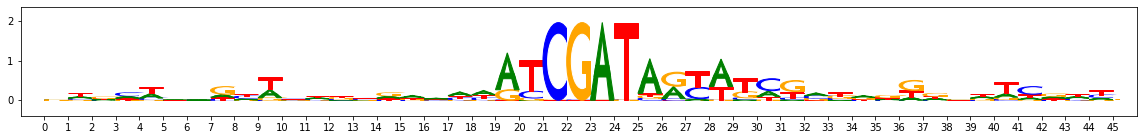

subcluster_8 size 12


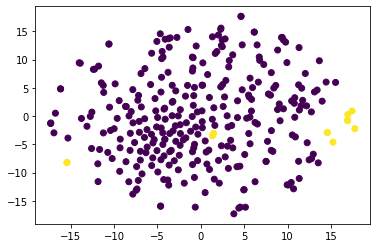

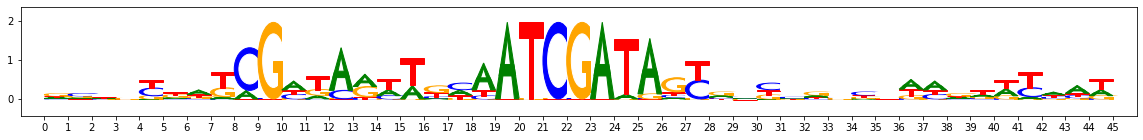

metacluster_0 pattern_1
total seqlets: 196
IC-scaled, fwd and rev:


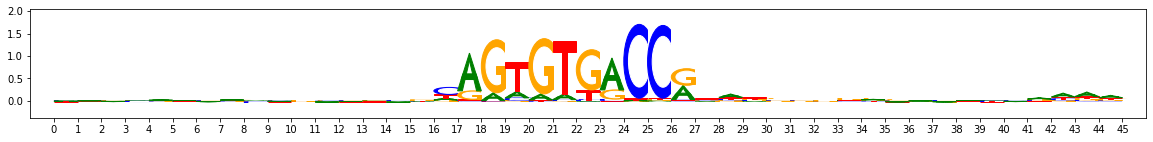

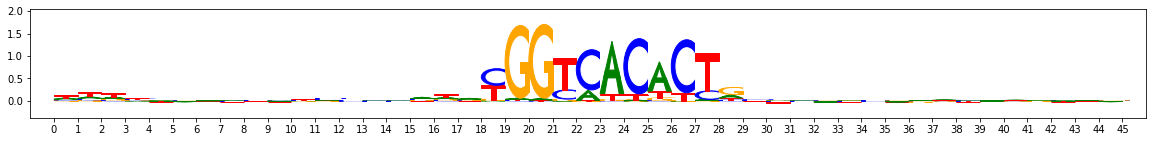

PLOTTING SUBCLUSTERS


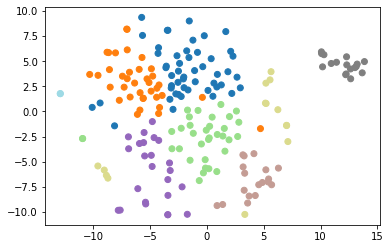

subcluster_0 size 50


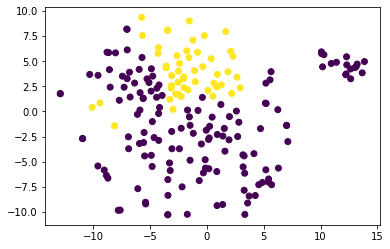

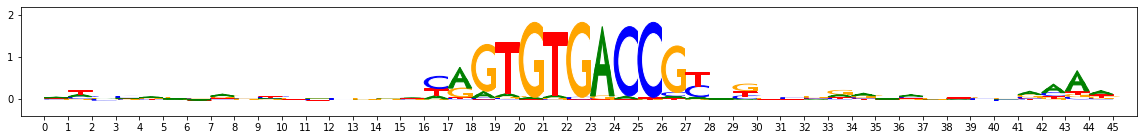

subcluster_1 size 37


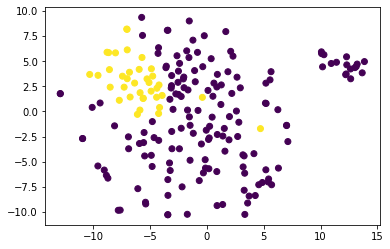

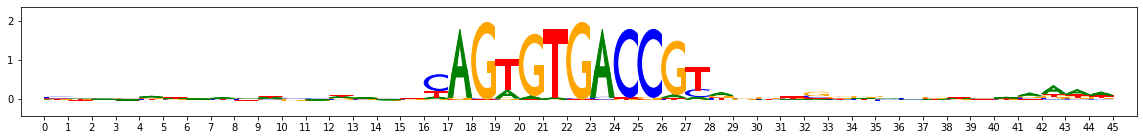

subcluster_2 size 34


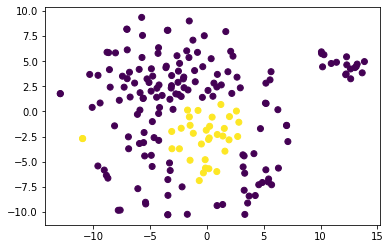

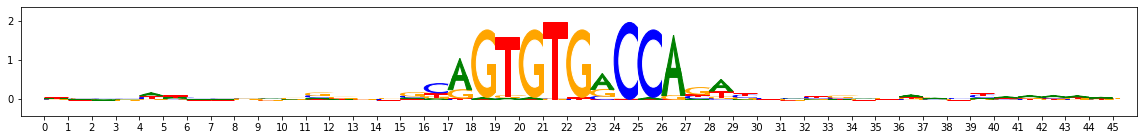

subcluster_3 size 24


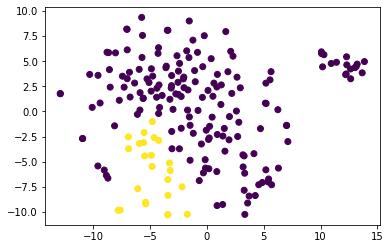

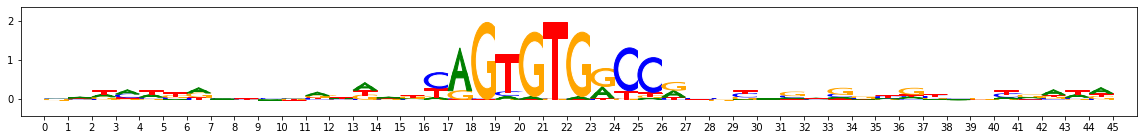

subcluster_4 size 18


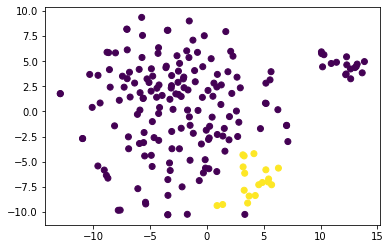

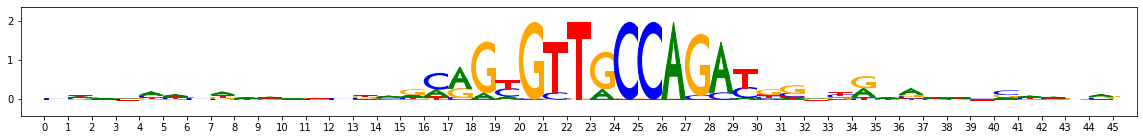

subcluster_5 size 17


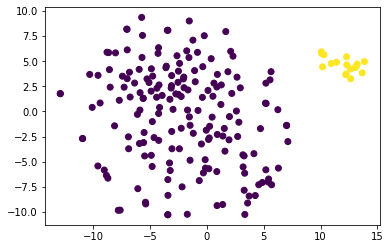

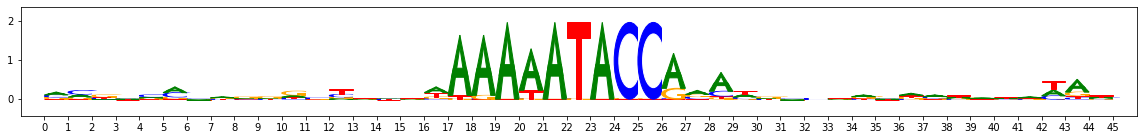

subcluster_6 size 14


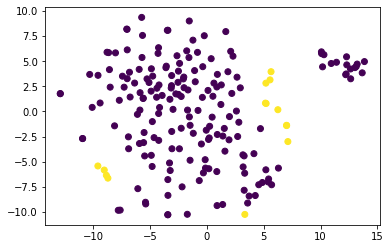

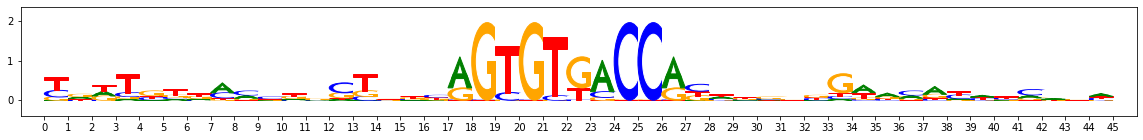

subcluster_7 size 2


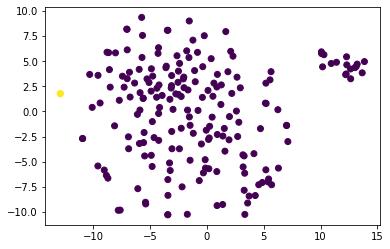

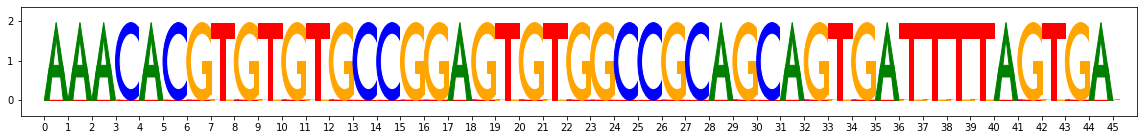

metacluster_0 pattern_2
total seqlets: 101
IC-scaled, fwd and rev:


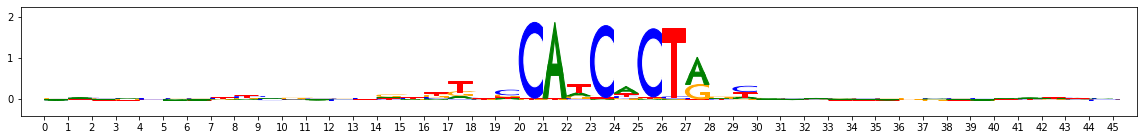

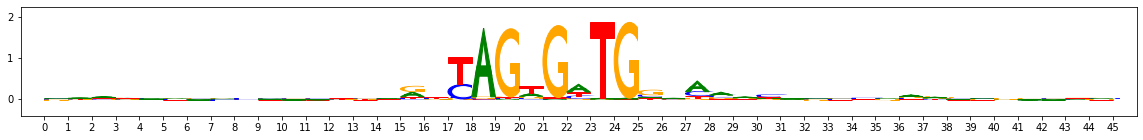

PLOTTING SUBCLUSTERS


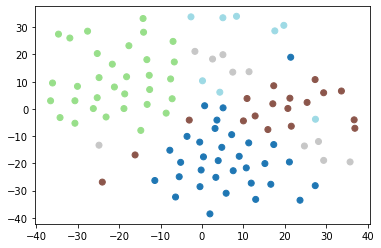

subcluster_0 size 33


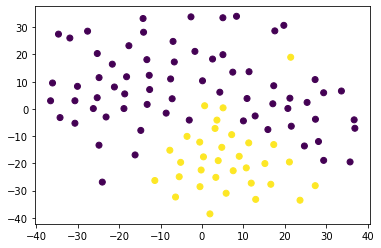

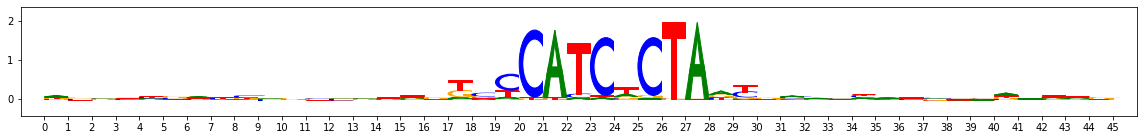

subcluster_1 size 32


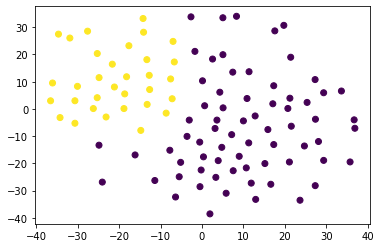

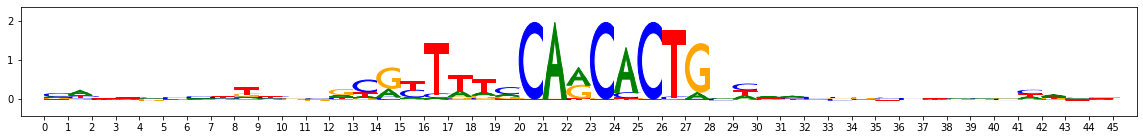

subcluster_2 size 18


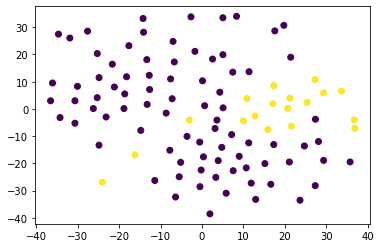

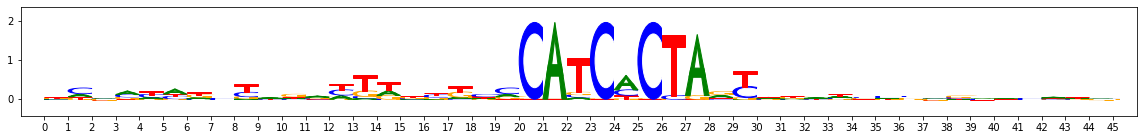

subcluster_3 size 10


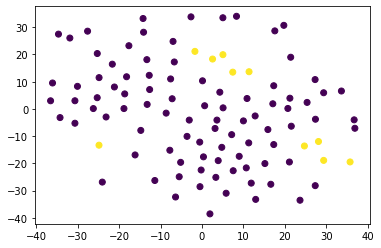

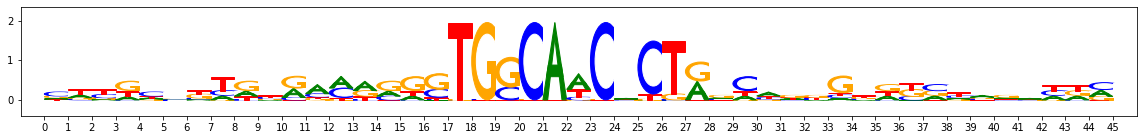

subcluster_4 size 8


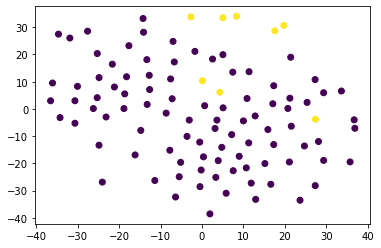

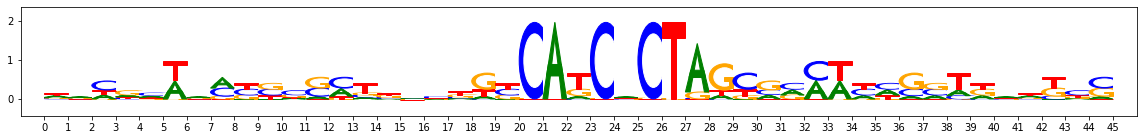

metacluster_0 pattern_3
total seqlets: 48
IC-scaled, fwd and rev:


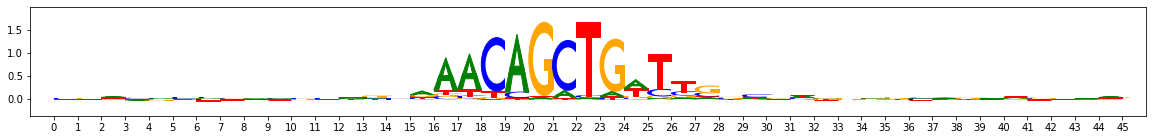

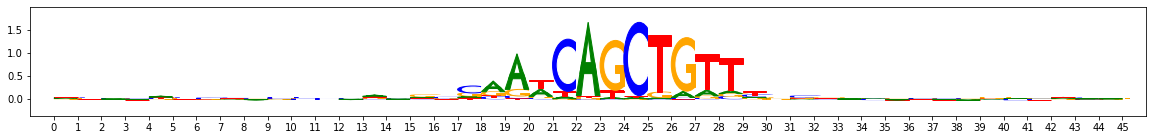

PLOTTING SUBCLUSTERS


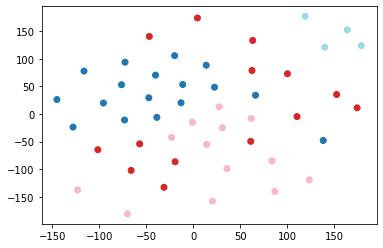

subcluster_0 size 17


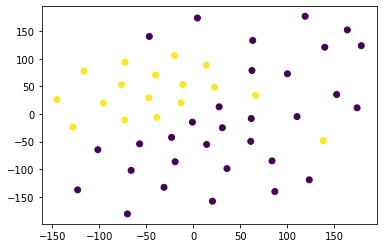

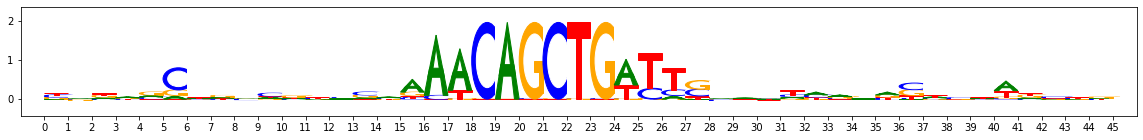

subcluster_1 size 14


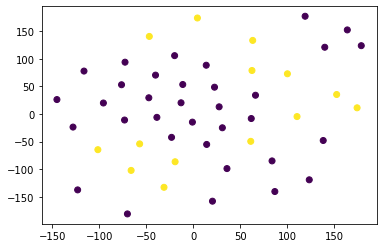

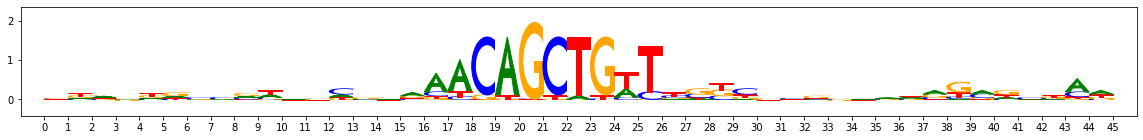

subcluster_2 size 13


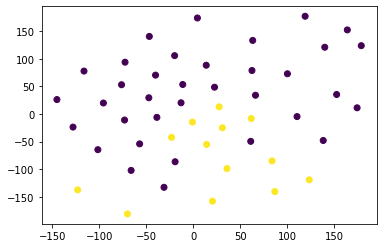

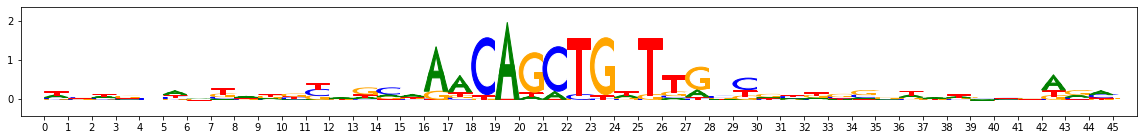

subcluster_3 size 4


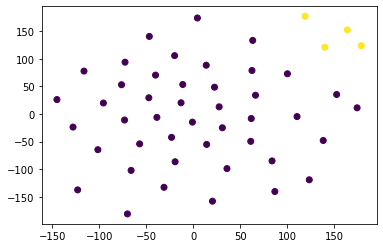

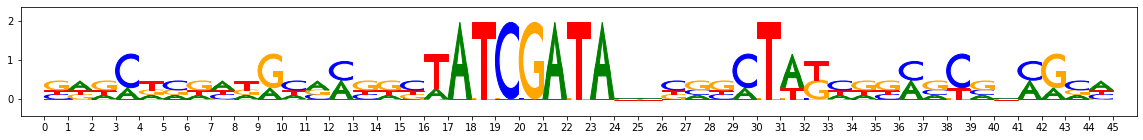

In [ ]:
# Visualize motifs
modisco_motif_plots('Hk_contrib_scores')

# Additional exercises to practice
- Train the model using the whole training data (link for the data at the beguining: Sequences_activity_all.txt) and compare the model performance and nucleotide contribution scores
- Try to improve the model by adapting the model hyperparamters or use a different architecture (e.g. add dilated convolutions or residual connections)